##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.01003029, -0.03423748,  0.00763177, -0.02628613,  0.03472349],
       [ 0.03486525,  0.03967843,  0.04985586, -0.00180235, -0.02386644],
       [ 0.03261597, -0.00733001,  0.02812122, -0.02205758,  0.01747707]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the  [Loading text tutorial](../load_data/text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[6346, 7961,    7, ...,    0,    0,    0],
       [ 857,  656,   15, ...,    0,    0,    0],
       [  19,   32,    9, ...,    0,    0,    0],
       ...,
       [  12,  284,   14, ...,    0,    0,    0],
       [  12,   81,  641, ..., 7961, 3388, 7975],
       [1124, 2454,  319, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 0s - loss: 0.6992 - accuracy: 0.7000

  13/2500 [..............................] - ETA: 10s - loss: 0.6926 - accuracy: 0.4923

  26/2500 [..............................] - ETA: 10s - loss: 0.6938 - accuracy: 0.5115

  39/2500 [..............................] - ETA: 9s - loss: 0.6935 - accuracy: 0.5128 

  52/2500 [..............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5038

  65/2500 [..............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5077

  78/2500 [..............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5128

  92/2500 [>.............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5011

 106/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5047

 119/2500 [>.............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.5109

 132/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5030

 145/2500 [>.............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.4979

 158/2500 [>.............................] - ETA: 9s - loss: 0.6928 - accuracy: 0.4899

 171/2500 [=>............................] - ETA: 9s - loss: 0.6929 - accuracy: 0.4912

 184/2500 [=>............................] - ETA: 9s - loss: 0.6935 - accuracy: 0.4995

 197/2500 [=>............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4964

 210/2500 [=>............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.4967

 223/2500 [=>............................] - ETA: 9s - loss: 0.6930 - accuracy: 0.4973

 236/2500 [=>............................] - ETA: 8s - loss: 0.6929 - accuracy: 0.5013

 249/2500 [=>............................] - ETA: 8s - loss: 0.6927 - accuracy: 0.4988

 262/2500 [==>...........................] - ETA: 8s - loss: 0.6926 - accuracy: 0.4969

 275/2500 [==>...........................] - ETA: 8s - loss: 0.6922 - accuracy: 0.4953

 288/2500 [==>...........................] - ETA: 8s - loss: 0.6922 - accuracy: 0.4986

 301/2500 [==>...........................] - ETA: 8s - loss: 0.6919 - accuracy: 0.4980

 315/2500 [==>...........................] - ETA: 8s - loss: 0.6918 - accuracy: 0.4987

 328/2500 [==>...........................] - ETA: 8s - loss: 0.6915 - accuracy: 0.5012

 342/2500 [===>..........................] - ETA: 8s - loss: 0.6914 - accuracy: 0.5020

 356/2500 [===>..........................] - ETA: 8s - loss: 0.6914 - accuracy: 0.4980

 369/2500 [===>..........................] - ETA: 8s - loss: 0.6908 - accuracy: 0.4970

 382/2500 [===>..........................] - ETA: 8s - loss: 0.6907 - accuracy: 0.4966

 395/2500 [===>..........................] - ETA: 8s - loss: 0.6905 - accuracy: 0.4962

 408/2500 [===>..........................] - ETA: 8s - loss: 0.6901 - accuracy: 0.4961

 421/2500 [====>.........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.4960

 434/2500 [====>.........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.4959

 447/2500 [====>.........................] - ETA: 8s - loss: 0.6892 - accuracy: 0.4960

 460/2500 [====>.........................] - ETA: 8s - loss: 0.6888 - accuracy: 0.4948

 473/2500 [====>.........................] - ETA: 7s - loss: 0.6883 - accuracy: 0.4928

 486/2500 [====>.........................] - ETA: 7s - loss: 0.6880 - accuracy: 0.4940

 500/2500 [=====>........................] - ETA: 7s - loss: 0.6877 - accuracy: 0.4952

 513/2500 [=====>........................] - ETA: 7s - loss: 0.6873 - accuracy: 0.4981

 527/2500 [=====>........................] - ETA: 7s - loss: 0.6867 - accuracy: 0.4992

 540/2500 [=====>........................] - ETA: 7s - loss: 0.6864 - accuracy: 0.4996

 554/2500 [=====>........................] - ETA: 7s - loss: 0.6858 - accuracy: 0.4982

 567/2500 [=====>........................] - ETA: 7s - loss: 0.6852 - accuracy: 0.4974

 580/2500 [=====>........................] - ETA: 7s - loss: 0.6842 - accuracy: 0.4969

 593/2500 [======>.......................] - ETA: 7s - loss: 0.6833 - accuracy: 0.4980

 606/2500 [======>.......................] - ETA: 7s - loss: 0.6826 - accuracy: 0.4983

 619/2500 [======>.......................] - ETA: 7s - loss: 0.6822 - accuracy: 0.4989

 633/2500 [======>.......................] - ETA: 7s - loss: 0.6815 - accuracy: 0.4989

 646/2500 [======>.......................] - ETA: 7s - loss: 0.6809 - accuracy: 0.4986

 659/2500 [======>.......................] - ETA: 7s - loss: 0.6801 - accuracy: 0.5000

 672/2500 [=======>......................] - ETA: 7s - loss: 0.6791 - accuracy: 0.5007

 685/2500 [=======>......................] - ETA: 7s - loss: 0.6784 - accuracy: 0.5003

 698/2500 [=======>......................] - ETA: 7s - loss: 0.6776 - accuracy: 0.5000

 711/2500 [=======>......................] - ETA: 7s - loss: 0.6768 - accuracy: 0.5017

 724/2500 [=======>......................] - ETA: 6s - loss: 0.6757 - accuracy: 0.5043

 738/2500 [=======>......................] - ETA: 6s - loss: 0.6746 - accuracy: 0.5058

 751/2500 [========>.....................] - ETA: 6s - loss: 0.6737 - accuracy: 0.5073

 764/2500 [========>.....................] - ETA: 6s - loss: 0.6728 - accuracy: 0.5080

 776/2500 [========>.....................] - ETA: 6s - loss: 0.6721 - accuracy: 0.5085

 788/2500 [========>.....................] - ETA: 6s - loss: 0.6711 - accuracy: 0.5098

 800/2500 [========>.....................] - ETA: 6s - loss: 0.6699 - accuracy: 0.5116

 812/2500 [========>.....................] - ETA: 6s - loss: 0.6686 - accuracy: 0.5139

 824/2500 [========>.....................] - ETA: 6s - loss: 0.6674 - accuracy: 0.5153

 836/2500 [=========>....................] - ETA: 6s - loss: 0.6659 - accuracy: 0.5156

 849/2500 [=========>....................] - ETA: 6s - loss: 0.6645 - accuracy: 0.5184

 860/2500 [=========>....................] - ETA: 6s - loss: 0.6635 - accuracy: 0.5200

 872/2500 [=========>....................] - ETA: 6s - loss: 0.6624 - accuracy: 0.5212

 884/2500 [=========>....................] - ETA: 6s - loss: 0.6611 - accuracy: 0.5226

 896/2500 [=========>....................] - ETA: 6s - loss: 0.6599 - accuracy: 0.5249

 908/2500 [=========>....................] - ETA: 6s - loss: 0.6582 - accuracy: 0.5262

 920/2500 [==========>...................] - ETA: 6s - loss: 0.6566 - accuracy: 0.5280

 932/2500 [==========>...................] - ETA: 6s - loss: 0.6552 - accuracy: 0.5292

 944/2500 [==========>...................] - ETA: 6s - loss: 0.6539 - accuracy: 0.5326

 956/2500 [==========>...................] - ETA: 6s - loss: 0.6528 - accuracy: 0.5334

 968/2500 [==========>...................] - ETA: 6s - loss: 0.6512 - accuracy: 0.5362

 980/2500 [==========>...................] - ETA: 6s - loss: 0.6499 - accuracy: 0.5378

 992/2500 [==========>...................] - ETA: 6s - loss: 0.6485 - accuracy: 0.5395

1003/2500 [===========>..................] - ETA: 6s - loss: 0.6470 - accuracy: 0.5421

1015/2500 [===========>..................] - ETA: 5s - loss: 0.6453 - accuracy: 0.5441

1027/2500 [===========>..................] - ETA: 5s - loss: 0.6436 - accuracy: 0.5470

1038/2500 [===========>..................] - ETA: 5s - loss: 0.6426 - accuracy: 0.5480

1050/2500 [===========>..................] - ETA: 5s - loss: 0.6413 - accuracy: 0.5494

1062/2500 [===========>..................] - ETA: 5s - loss: 0.6396 - accuracy: 0.5513

1074/2500 [===========>..................] - ETA: 5s - loss: 0.6381 - accuracy: 0.5540

1086/2500 [============>.................] - ETA: 5s - loss: 0.6366 - accuracy: 0.5568

1098/2500 [============>.................] - ETA: 5s - loss: 0.6353 - accuracy: 0.5592

1110/2500 [============>.................] - ETA: 5s - loss: 0.6338 - accuracy: 0.5607

1122/2500 [============>.................] - ETA: 5s - loss: 0.6319 - accuracy: 0.5635

1134/2500 [============>.................] - ETA: 5s - loss: 0.6302 - accuracy: 0.5656

1146/2500 [============>.................] - ETA: 5s - loss: 0.6284 - accuracy: 0.5675

1158/2500 [============>.................] - ETA: 5s - loss: 0.6266 - accuracy: 0.5693

1170/2500 [=============>................] - ETA: 5s - loss: 0.6251 - accuracy: 0.5709

1182/2500 [=============>................] - ETA: 5s - loss: 0.6236 - accuracy: 0.5727

1194/2500 [=============>................] - ETA: 5s - loss: 0.6225 - accuracy: 0.5736

1206/2500 [=============>................] - ETA: 5s - loss: 0.6208 - accuracy: 0.5757

1218/2500 [=============>................] - ETA: 5s - loss: 0.6189 - accuracy: 0.5776

1230/2500 [=============>................] - ETA: 5s - loss: 0.6180 - accuracy: 0.5790

1242/2500 [=============>................] - ETA: 5s - loss: 0.6159 - accuracy: 0.5811

1254/2500 [==============>...............] - ETA: 5s - loss: 0.6146 - accuracy: 0.5834

1266/2500 [==============>...............] - ETA: 5s - loss: 0.6132 - accuracy: 0.5857

1278/2500 [==============>...............] - ETA: 5s - loss: 0.6117 - accuracy: 0.5878

1290/2500 [==============>...............] - ETA: 4s - loss: 0.6101 - accuracy: 0.5888

1302/2500 [==============>...............] - ETA: 4s - loss: 0.6084 - accuracy: 0.5914

1314/2500 [==============>...............] - ETA: 4s - loss: 0.6073 - accuracy: 0.5926

1326/2500 [==============>...............] - ETA: 4s - loss: 0.6056 - accuracy: 0.5947

1338/2500 [===============>..............] - ETA: 4s - loss: 0.6044 - accuracy: 0.5953

1350/2500 [===============>..............] - ETA: 4s - loss: 0.6030 - accuracy: 0.5973

1362/2500 [===============>..............] - ETA: 4s - loss: 0.6017 - accuracy: 0.5989

1374/2500 [===============>..............] - ETA: 4s - loss: 0.6003 - accuracy: 0.6007

1386/2500 [===============>..............] - ETA: 4s - loss: 0.5986 - accuracy: 0.6022

1398/2500 [===============>..............] - ETA: 4s - loss: 0.5973 - accuracy: 0.6034

1410/2500 [===============>..............] - ETA: 4s - loss: 0.5961 - accuracy: 0.6052

1422/2500 [================>.............] - ETA: 4s - loss: 0.5948 - accuracy: 0.6063

1434/2500 [================>.............] - ETA: 4s - loss: 0.5937 - accuracy: 0.6080

1446/2500 [================>.............] - ETA: 4s - loss: 0.5922 - accuracy: 0.6093

1458/2500 [================>.............] - ETA: 4s - loss: 0.5905 - accuracy: 0.6106

1470/2500 [================>.............] - ETA: 4s - loss: 0.5893 - accuracy: 0.6122

1482/2500 [================>.............] - ETA: 4s - loss: 0.5878 - accuracy: 0.6140

1494/2500 [================>.............] - ETA: 4s - loss: 0.5867 - accuracy: 0.6149

1506/2500 [=================>............] - ETA: 4s - loss: 0.5851 - accuracy: 0.6163

1518/2500 [=================>............] - ETA: 4s - loss: 0.5841 - accuracy: 0.6177

1530/2500 [=================>............] - ETA: 4s - loss: 0.5828 - accuracy: 0.6190

1542/2500 [=================>............] - ETA: 3s - loss: 0.5810 - accuracy: 0.6208

1554/2500 [=================>............] - ETA: 3s - loss: 0.5800 - accuracy: 0.6228

1566/2500 [=================>............] - ETA: 3s - loss: 0.5788 - accuracy: 0.6236

1578/2500 [=================>............] - ETA: 3s - loss: 0.5772 - accuracy: 0.6255

1590/2500 [==================>...........] - ETA: 3s - loss: 0.5761 - accuracy: 0.6268

1602/2500 [==================>...........] - ETA: 3s - loss: 0.5746 - accuracy: 0.6281

1614/2500 [==================>...........] - ETA: 3s - loss: 0.5734 - accuracy: 0.6294

1626/2500 [==================>...........] - ETA: 3s - loss: 0.5727 - accuracy: 0.6303

1637/2500 [==================>...........] - ETA: 3s - loss: 0.5712 - accuracy: 0.6319

1649/2500 [==================>...........] - ETA: 3s - loss: 0.5700 - accuracy: 0.6334

1661/2500 [==================>...........] - ETA: 3s - loss: 0.5692 - accuracy: 0.6347

1673/2500 [===================>..........] - ETA: 3s - loss: 0.5680 - accuracy: 0.6360

1685/2500 [===================>..........] - ETA: 3s - loss: 0.5671 - accuracy: 0.6370

1697/2500 [===================>..........] - ETA: 3s - loss: 0.5657 - accuracy: 0.6387

1709/2500 [===================>..........] - ETA: 3s - loss: 0.5649 - accuracy: 0.6394

1721/2500 [===================>..........] - ETA: 3s - loss: 0.5634 - accuracy: 0.6410

1733/2500 [===================>..........] - ETA: 3s - loss: 0.5624 - accuracy: 0.6423

1745/2500 [===================>..........] - ETA: 3s - loss: 0.5611 - accuracy: 0.6436

1757/2500 [====================>.........] - ETA: 3s - loss: 0.5593 - accuracy: 0.6452

1769/2500 [====================>.........] - ETA: 3s - loss: 0.5578 - accuracy: 0.6463

1781/2500 [====================>.........] - ETA: 3s - loss: 0.5566 - accuracy: 0.6478

1793/2500 [====================>.........] - ETA: 2s - loss: 0.5557 - accuracy: 0.6488

1804/2500 [====================>.........] - ETA: 2s - loss: 0.5547 - accuracy: 0.6498

1816/2500 [====================>.........] - ETA: 2s - loss: 0.5540 - accuracy: 0.6510

1828/2500 [====================>.........] - ETA: 2s - loss: 0.5527 - accuracy: 0.6521

1840/2500 [=====================>........] - ETA: 2s - loss: 0.5518 - accuracy: 0.6530

1852/2500 [=====================>........] - ETA: 2s - loss: 0.5511 - accuracy: 0.6539

1864/2500 [=====================>........] - ETA: 2s - loss: 0.5506 - accuracy: 0.6542

1876/2500 [=====================>........] - ETA: 2s - loss: 0.5496 - accuracy: 0.6555

1888/2500 [=====================>........] - ETA: 2s - loss: 0.5481 - accuracy: 0.6569

1900/2500 [=====================>........] - ETA: 2s - loss: 0.5471 - accuracy: 0.6581

1912/2500 [=====================>........] - ETA: 2s - loss: 0.5470 - accuracy: 0.6584

1924/2500 [======================>.......] - ETA: 2s - loss: 0.5458 - accuracy: 0.6597

1936/2500 [======================>.......] - ETA: 2s - loss: 0.5448 - accuracy: 0.6604

1948/2500 [======================>.......] - ETA: 2s - loss: 0.5435 - accuracy: 0.6618

1960/2500 [======================>.......] - ETA: 2s - loss: 0.5426 - accuracy: 0.6631

1971/2500 [======================>.......] - ETA: 2s - loss: 0.5418 - accuracy: 0.6638

1983/2500 [======================>.......] - ETA: 2s - loss: 0.5411 - accuracy: 0.6649

1995/2500 [======================>.......] - ETA: 2s - loss: 0.5402 - accuracy: 0.6657

2007/2500 [=======================>......] - ETA: 2s - loss: 0.5394 - accuracy: 0.6666

2019/2500 [=======================>......] - ETA: 2s - loss: 0.5381 - accuracy: 0.6680

2031/2500 [=======================>......] - ETA: 1s - loss: 0.5371 - accuracy: 0.6690

2042/2500 [=======================>......] - ETA: 1s - loss: 0.5359 - accuracy: 0.6703

2054/2500 [=======================>......] - ETA: 1s - loss: 0.5357 - accuracy: 0.6707

2066/2500 [=======================>......] - ETA: 1s - loss: 0.5347 - accuracy: 0.6719

2078/2500 [=======================>......] - ETA: 1s - loss: 0.5339 - accuracy: 0.6726

2090/2500 [========================>.....] - ETA: 1s - loss: 0.5331 - accuracy: 0.6734

2102/2500 [========================>.....] - ETA: 1s - loss: 0.5320 - accuracy: 0.6742

2114/2500 [========================>.....] - ETA: 1s - loss: 0.5308 - accuracy: 0.6755

2126/2500 [========================>.....] - ETA: 1s - loss: 0.5299 - accuracy: 0.6764

2138/2500 [========================>.....] - ETA: 1s - loss: 0.5291 - accuracy: 0.6771

2150/2500 [========================>.....] - ETA: 1s - loss: 0.5282 - accuracy: 0.6781

2162/2500 [========================>.....] - ETA: 1s - loss: 0.5271 - accuracy: 0.6789

2174/2500 [=========================>....] - ETA: 1s - loss: 0.5263 - accuracy: 0.6799

2186/2500 [=========================>....] - ETA: 1s - loss: 0.5250 - accuracy: 0.6809

2198/2500 [=========================>....] - ETA: 1s - loss: 0.5241 - accuracy: 0.6816

2210/2500 [=========================>....] - ETA: 1s - loss: 0.5233 - accuracy: 0.6824

2222/2500 [=========================>....] - ETA: 1s - loss: 0.5225 - accuracy: 0.6835

2234/2500 [=========================>....] - ETA: 1s - loss: 0.5216 - accuracy: 0.6845

2246/2500 [=========================>....] - ETA: 1s - loss: 0.5209 - accuracy: 0.6852

2258/2500 [==========================>...] - ETA: 1s - loss: 0.5197 - accuracy: 0.6862

2270/2500 [==========================>...] - ETA: 0s - loss: 0.5189 - accuracy: 0.6870

2282/2500 [==========================>...] - ETA: 0s - loss: 0.5178 - accuracy: 0.6879

2294/2500 [==========================>...] - ETA: 0s - loss: 0.5171 - accuracy: 0.6888

2306/2500 [==========================>...] - ETA: 0s - loss: 0.5159 - accuracy: 0.6897

2318/2500 [==========================>...] - ETA: 0s - loss: 0.5145 - accuracy: 0.6906

2329/2500 [==========================>...] - ETA: 0s - loss: 0.5136 - accuracy: 0.6917

2341/2500 [===========================>..] - ETA: 0s - loss: 0.5126 - accuracy: 0.6927

2353/2500 [===========================>..] - ETA: 0s - loss: 0.5121 - accuracy: 0.6933

2365/2500 [===========================>..] - ETA: 0s - loss: 0.5116 - accuracy: 0.6940

2377/2500 [===========================>..] - ETA: 0s - loss: 0.5114 - accuracy: 0.6940

2389/2500 [===========================>..] - ETA: 0s - loss: 0.5104 - accuracy: 0.6951

2401/2500 [===========================>..] - ETA: 0s - loss: 0.5095 - accuracy: 0.6956

2414/2500 [===========================>..] - ETA: 0s - loss: 0.5087 - accuracy: 0.6964

2426/2500 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.6969

2439/2500 [============================>.] - ETA: 0s - loss: 0.5069 - accuracy: 0.6980

2451/2500 [============================>.] - ETA: 0s - loss: 0.5063 - accuracy: 0.6986

2463/2500 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.6994

2475/2500 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.7000

2488/2500 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.7008

2500/2500 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.7016

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5027 - accuracy: 0.7016 - val_loss: 0.3560 - val_accuracy: 0.8250


Epoch 2/10
   1/2500 [..............................] - ETA: 0s - loss: 0.4379 - accuracy: 0.7000

  13/2500 [..............................] - ETA: 9s - loss: 0.3922 - accuracy: 0.8077

  25/2500 [..............................] - ETA: 10s - loss: 0.3240 - accuracy: 0.8520

  37/2500 [..............................] - ETA: 10s - loss: 0.3191 - accuracy: 0.8541

  49/2500 [..............................] - ETA: 10s - loss: 0.3414 - accuracy: 0.8429

  61/2500 [..............................] - ETA: 10s - loss: 0.3240 - accuracy: 0.8525

  73/2500 [..............................] - ETA: 10s - loss: 0.3232 - accuracy: 0.8575

  85/2500 [>.............................] - ETA: 10s - loss: 0.3192 - accuracy: 0.8588

  97/2500 [>.............................] - ETA: 10s - loss: 0.3182 - accuracy: 0.8619

 109/2500 [>.............................] - ETA: 10s - loss: 0.3238 - accuracy: 0.8596

 121/2500 [>.............................] - ETA: 10s - loss: 0.3196 - accuracy: 0.8587

 133/2500 [>.............................] - ETA: 10s - loss: 0.3187 - accuracy: 0.8624

 145/2500 [>.............................] - ETA: 10s - loss: 0.3169 - accuracy: 0.8607

 156/2500 [>.............................] - ETA: 10s - loss: 0.3210 - accuracy: 0.8564

 168/2500 [=>............................] - ETA: 10s - loss: 0.3213 - accuracy: 0.8554

 180/2500 [=>............................] - ETA: 10s - loss: 0.3235 - accuracy: 0.8544

 192/2500 [=>............................] - ETA: 9s - loss: 0.3223 - accuracy: 0.8562 

 204/2500 [=>............................] - ETA: 9s - loss: 0.3218 - accuracy: 0.8574

 216/2500 [=>............................] - ETA: 9s - loss: 0.3166 - accuracy: 0.8602

 228/2500 [=>............................] - ETA: 9s - loss: 0.3186 - accuracy: 0.8605

 240/2500 [=>............................] - ETA: 9s - loss: 0.3200 - accuracy: 0.8600

 252/2500 [==>...........................] - ETA: 9s - loss: 0.3182 - accuracy: 0.8611

 264/2500 [==>...........................] - ETA: 9s - loss: 0.3187 - accuracy: 0.8614

 276/2500 [==>...........................] - ETA: 9s - loss: 0.3192 - accuracy: 0.8623

 288/2500 [==>...........................] - ETA: 9s - loss: 0.3147 - accuracy: 0.8646

 300/2500 [==>...........................] - ETA: 9s - loss: 0.3163 - accuracy: 0.8643

 312/2500 [==>...........................] - ETA: 9s - loss: 0.3153 - accuracy: 0.8644

 324/2500 [==>...........................] - ETA: 9s - loss: 0.3144 - accuracy: 0.8633

 336/2500 [===>..........................] - ETA: 9s - loss: 0.3143 - accuracy: 0.8631

 348/2500 [===>..........................] - ETA: 9s - loss: 0.3143 - accuracy: 0.8638

 360/2500 [===>..........................] - ETA: 9s - loss: 0.3126 - accuracy: 0.8633

 372/2500 [===>..........................] - ETA: 9s - loss: 0.3128 - accuracy: 0.8632

 384/2500 [===>..........................] - ETA: 9s - loss: 0.3114 - accuracy: 0.8638

 395/2500 [===>..........................] - ETA: 9s - loss: 0.3132 - accuracy: 0.8628

 407/2500 [===>..........................] - ETA: 9s - loss: 0.3117 - accuracy: 0.8634

 419/2500 [====>.........................] - ETA: 9s - loss: 0.3111 - accuracy: 0.8635

 431/2500 [====>.........................] - ETA: 8s - loss: 0.3108 - accuracy: 0.8640

 443/2500 [====>.........................] - ETA: 8s - loss: 0.3121 - accuracy: 0.8637

 455/2500 [====>.........................] - ETA: 8s - loss: 0.3141 - accuracy: 0.8620

 467/2500 [====>.........................] - ETA: 8s - loss: 0.3155 - accuracy: 0.8604

 479/2500 [====>.........................] - ETA: 8s - loss: 0.3148 - accuracy: 0.8605

 491/2500 [====>.........................] - ETA: 8s - loss: 0.3137 - accuracy: 0.8615

 503/2500 [=====>........................] - ETA: 8s - loss: 0.3133 - accuracy: 0.8620

 515/2500 [=====>........................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8635

 527/2500 [=====>........................] - ETA: 8s - loss: 0.3121 - accuracy: 0.8634

 539/2500 [=====>........................] - ETA: 8s - loss: 0.3109 - accuracy: 0.8646

 552/2500 [=====>........................] - ETA: 8s - loss: 0.3125 - accuracy: 0.8645

 565/2500 [=====>........................] - ETA: 8s - loss: 0.3120 - accuracy: 0.8639

 578/2500 [=====>........................] - ETA: 8s - loss: 0.3096 - accuracy: 0.8651

 591/2500 [======>.......................] - ETA: 8s - loss: 0.3112 - accuracy: 0.8653

 604/2500 [======>.......................] - ETA: 8s - loss: 0.3123 - accuracy: 0.8631

 617/2500 [======>.......................] - ETA: 8s - loss: 0.3115 - accuracy: 0.8635

 631/2500 [======>.......................] - ETA: 8s - loss: 0.3112 - accuracy: 0.8640

 644/2500 [======>.......................] - ETA: 7s - loss: 0.3101 - accuracy: 0.8646

 657/2500 [======>.......................] - ETA: 7s - loss: 0.3091 - accuracy: 0.8650

 671/2500 [=======>......................] - ETA: 7s - loss: 0.3095 - accuracy: 0.8642

 684/2500 [=======>......................] - ETA: 7s - loss: 0.3090 - accuracy: 0.8643

 698/2500 [=======>......................] - ETA: 7s - loss: 0.3071 - accuracy: 0.8652

 712/2500 [=======>......................] - ETA: 7s - loss: 0.3074 - accuracy: 0.8653

 725/2500 [=======>......................] - ETA: 7s - loss: 0.3074 - accuracy: 0.8652

 738/2500 [=======>......................] - ETA: 7s - loss: 0.3076 - accuracy: 0.8657

 752/2500 [========>.....................] - ETA: 7s - loss: 0.3081 - accuracy: 0.8658

 765/2500 [========>.....................] - ETA: 7s - loss: 0.3081 - accuracy: 0.8659

 778/2500 [========>.....................] - ETA: 7s - loss: 0.3083 - accuracy: 0.8656

 791/2500 [========>.....................] - ETA: 7s - loss: 0.3073 - accuracy: 0.8662

 804/2500 [========>.....................] - ETA: 7s - loss: 0.3074 - accuracy: 0.8670

 817/2500 [========>.....................] - ETA: 7s - loss: 0.3065 - accuracy: 0.8672

 830/2500 [========>.....................] - ETA: 7s - loss: 0.3058 - accuracy: 0.8680

 843/2500 [=========>....................] - ETA: 6s - loss: 0.3059 - accuracy: 0.8676

 856/2500 [=========>....................] - ETA: 6s - loss: 0.3053 - accuracy: 0.8678

 869/2500 [=========>....................] - ETA: 6s - loss: 0.3046 - accuracy: 0.8687

 882/2500 [=========>....................] - ETA: 6s - loss: 0.3043 - accuracy: 0.8690

 895/2500 [=========>....................] - ETA: 6s - loss: 0.3035 - accuracy: 0.8695

 908/2500 [=========>....................] - ETA: 6s - loss: 0.3019 - accuracy: 0.8704

 921/2500 [==========>...................] - ETA: 6s - loss: 0.3014 - accuracy: 0.8708

 934/2500 [==========>...................] - ETA: 6s - loss: 0.3011 - accuracy: 0.8711

 947/2500 [==========>...................] - ETA: 6s - loss: 0.3007 - accuracy: 0.8714

 960/2500 [==========>...................] - ETA: 6s - loss: 0.3009 - accuracy: 0.8710

 973/2500 [==========>...................] - ETA: 6s - loss: 0.3001 - accuracy: 0.8711

 986/2500 [==========>...................] - ETA: 6s - loss: 0.3000 - accuracy: 0.8716

1000/2500 [===========>..................] - ETA: 6s - loss: 0.2994 - accuracy: 0.8716

1013/2500 [===========>..................] - ETA: 6s - loss: 0.2995 - accuracy: 0.8717

1026/2500 [===========>..................] - ETA: 6s - loss: 0.2987 - accuracy: 0.8723

1039/2500 [===========>..................] - ETA: 6s - loss: 0.2990 - accuracy: 0.8723

1053/2500 [===========>..................] - ETA: 5s - loss: 0.2987 - accuracy: 0.8726

1066/2500 [===========>..................] - ETA: 5s - loss: 0.2981 - accuracy: 0.8732

1080/2500 [===========>..................] - ETA: 5s - loss: 0.2977 - accuracy: 0.8734

1093/2500 [============>.................] - ETA: 5s - loss: 0.2991 - accuracy: 0.8732

1106/2500 [============>.................] - ETA: 5s - loss: 0.2997 - accuracy: 0.8733

1119/2500 [============>.................] - ETA: 5s - loss: 0.2987 - accuracy: 0.8735

1132/2500 [============>.................] - ETA: 5s - loss: 0.2985 - accuracy: 0.8735

1145/2500 [============>.................] - ETA: 5s - loss: 0.2972 - accuracy: 0.8741

1158/2500 [============>.................] - ETA: 5s - loss: 0.2971 - accuracy: 0.8741

1171/2500 [=============>................] - ETA: 5s - loss: 0.2965 - accuracy: 0.8738

1184/2500 [=============>................] - ETA: 5s - loss: 0.2965 - accuracy: 0.8741

1197/2500 [=============>................] - ETA: 5s - loss: 0.2961 - accuracy: 0.8739

1211/2500 [=============>................] - ETA: 5s - loss: 0.2952 - accuracy: 0.8745

1224/2500 [=============>................] - ETA: 5s - loss: 0.2947 - accuracy: 0.8748

1237/2500 [=============>................] - ETA: 5s - loss: 0.2937 - accuracy: 0.8754

1250/2500 [==============>...............] - ETA: 5s - loss: 0.2934 - accuracy: 0.8754

1263/2500 [==============>...............] - ETA: 5s - loss: 0.2936 - accuracy: 0.8751

1276/2500 [==============>...............] - ETA: 5s - loss: 0.2934 - accuracy: 0.8750

1289/2500 [==============>...............] - ETA: 4s - loss: 0.2937 - accuracy: 0.8750

1302/2500 [==============>...............] - ETA: 4s - loss: 0.2928 - accuracy: 0.8754

1315/2500 [==============>...............] - ETA: 4s - loss: 0.2924 - accuracy: 0.8752

1328/2500 [==============>...............] - ETA: 4s - loss: 0.2915 - accuracy: 0.8757

1341/2500 [===============>..............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8753

1355/2500 [===============>..............] - ETA: 4s - loss: 0.2914 - accuracy: 0.8756

1368/2500 [===============>..............] - ETA: 4s - loss: 0.2915 - accuracy: 0.8755

1381/2500 [===============>..............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8752

1394/2500 [===============>..............] - ETA: 4s - loss: 0.2913 - accuracy: 0.8755

1407/2500 [===============>..............] - ETA: 4s - loss: 0.2911 - accuracy: 0.8757

1420/2500 [================>.............] - ETA: 4s - loss: 0.2903 - accuracy: 0.8761

1433/2500 [================>.............] - ETA: 4s - loss: 0.2901 - accuracy: 0.8763

1446/2500 [================>.............] - ETA: 4s - loss: 0.2896 - accuracy: 0.8763

1460/2500 [================>.............] - ETA: 4s - loss: 0.2892 - accuracy: 0.8767

1473/2500 [================>.............] - ETA: 4s - loss: 0.2895 - accuracy: 0.8766

1486/2500 [================>.............] - ETA: 4s - loss: 0.2887 - accuracy: 0.8772

1500/2500 [=================>............] - ETA: 4s - loss: 0.2885 - accuracy: 0.8773

1514/2500 [=================>............] - ETA: 4s - loss: 0.2887 - accuracy: 0.8772

1527/2500 [=================>............] - ETA: 3s - loss: 0.2885 - accuracy: 0.8774

1540/2500 [=================>............] - ETA: 3s - loss: 0.2884 - accuracy: 0.8775

1553/2500 [=================>............] - ETA: 3s - loss: 0.2879 - accuracy: 0.8777

1566/2500 [=================>............] - ETA: 3s - loss: 0.2877 - accuracy: 0.8780

1580/2500 [=================>............] - ETA: 3s - loss: 0.2876 - accuracy: 0.8779

1593/2500 [==================>...........] - ETA: 3s - loss: 0.2875 - accuracy: 0.8780

1606/2500 [==================>...........] - ETA: 3s - loss: 0.2867 - accuracy: 0.8785

1619/2500 [==================>...........] - ETA: 3s - loss: 0.2871 - accuracy: 0.8784

1632/2500 [==================>...........] - ETA: 3s - loss: 0.2869 - accuracy: 0.8786

1645/2500 [==================>...........] - ETA: 3s - loss: 0.2870 - accuracy: 0.8786

1658/2500 [==================>...........] - ETA: 3s - loss: 0.2868 - accuracy: 0.8787

1671/2500 [===================>..........] - ETA: 3s - loss: 0.2864 - accuracy: 0.8788

1684/2500 [===================>..........] - ETA: 3s - loss: 0.2865 - accuracy: 0.8788

1697/2500 [===================>..........] - ETA: 3s - loss: 0.2863 - accuracy: 0.8786

1710/2500 [===================>..........] - ETA: 3s - loss: 0.2862 - accuracy: 0.8789

1723/2500 [===================>..........] - ETA: 3s - loss: 0.2859 - accuracy: 0.8793

1736/2500 [===================>..........] - ETA: 3s - loss: 0.2860 - accuracy: 0.8790

1749/2500 [===================>..........] - ETA: 3s - loss: 0.2861 - accuracy: 0.8791

1762/2500 [====================>.........] - ETA: 2s - loss: 0.2859 - accuracy: 0.8792

1775/2500 [====================>.........] - ETA: 2s - loss: 0.2856 - accuracy: 0.8793

1788/2500 [====================>.........] - ETA: 2s - loss: 0.2858 - accuracy: 0.8795

1801/2500 [====================>.........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8795

1814/2500 [====================>.........] - ETA: 2s - loss: 0.2855 - accuracy: 0.8797

1827/2500 [====================>.........] - ETA: 2s - loss: 0.2857 - accuracy: 0.8800

1840/2500 [=====================>........] - ETA: 2s - loss: 0.2854 - accuracy: 0.8801

1853/2500 [=====================>........] - ETA: 2s - loss: 0.2855 - accuracy: 0.8802

1866/2500 [=====================>........] - ETA: 2s - loss: 0.2857 - accuracy: 0.8801

1880/2500 [=====================>........] - ETA: 2s - loss: 0.2856 - accuracy: 0.8803

1893/2500 [=====================>........] - ETA: 2s - loss: 0.2858 - accuracy: 0.8801

1906/2500 [=====================>........] - ETA: 2s - loss: 0.2857 - accuracy: 0.8802

1920/2500 [======================>.......] - ETA: 2s - loss: 0.2857 - accuracy: 0.8802

1933/2500 [======================>.......] - ETA: 2s - loss: 0.2860 - accuracy: 0.8802

1946/2500 [======================>.......] - ETA: 2s - loss: 0.2862 - accuracy: 0.8800

1959/2500 [======================>.......] - ETA: 2s - loss: 0.2858 - accuracy: 0.8803

1973/2500 [======================>.......] - ETA: 2s - loss: 0.2857 - accuracy: 0.8803

1986/2500 [======================>.......] - ETA: 2s - loss: 0.2853 - accuracy: 0.8806

1999/2500 [======================>.......] - ETA: 2s - loss: 0.2853 - accuracy: 0.8805

2012/2500 [=======================>......] - ETA: 1s - loss: 0.2853 - accuracy: 0.8807

2025/2500 [=======================>......] - ETA: 1s - loss: 0.2850 - accuracy: 0.8809

2038/2500 [=======================>......] - ETA: 1s - loss: 0.2851 - accuracy: 0.8811

2052/2500 [=======================>......] - ETA: 1s - loss: 0.2848 - accuracy: 0.8811

2065/2500 [=======================>......] - ETA: 1s - loss: 0.2845 - accuracy: 0.8811

2078/2500 [=======================>......] - ETA: 1s - loss: 0.2843 - accuracy: 0.8813

2092/2500 [========================>.....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8815

2105/2500 [========================>.....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8816

2118/2500 [========================>.....] - ETA: 1s - loss: 0.2841 - accuracy: 0.8817

2131/2500 [========================>.....] - ETA: 1s - loss: 0.2841 - accuracy: 0.8817

2144/2500 [========================>.....] - ETA: 1s - loss: 0.2837 - accuracy: 0.8818

2157/2500 [========================>.....] - ETA: 1s - loss: 0.2835 - accuracy: 0.8820

2170/2500 [=========================>....] - ETA: 1s - loss: 0.2829 - accuracy: 0.8824

2183/2500 [=========================>....] - ETA: 1s - loss: 0.2829 - accuracy: 0.8825

2196/2500 [=========================>....] - ETA: 1s - loss: 0.2832 - accuracy: 0.8823

2209/2500 [=========================>....] - ETA: 1s - loss: 0.2833 - accuracy: 0.8822

2222/2500 [=========================>....] - ETA: 1s - loss: 0.2828 - accuracy: 0.8824

2235/2500 [=========================>....] - ETA: 1s - loss: 0.2825 - accuracy: 0.8825

2248/2500 [=========================>....] - ETA: 1s - loss: 0.2821 - accuracy: 0.8826

2261/2500 [==========================>...] - ETA: 0s - loss: 0.2820 - accuracy: 0.8828

2274/2500 [==========================>...] - ETA: 0s - loss: 0.2815 - accuracy: 0.8830

2287/2500 [==========================>...] - ETA: 0s - loss: 0.2816 - accuracy: 0.8829

2300/2500 [==========================>...] - ETA: 0s - loss: 0.2812 - accuracy: 0.8830

2313/2500 [==========================>...] - ETA: 0s - loss: 0.2814 - accuracy: 0.8829

2326/2500 [==========================>...] - ETA: 0s - loss: 0.2812 - accuracy: 0.8830

2339/2500 [===========================>..] - ETA: 0s - loss: 0.2808 - accuracy: 0.8833

2352/2500 [===========================>..] - ETA: 0s - loss: 0.2806 - accuracy: 0.8835

2366/2500 [===========================>..] - ETA: 0s - loss: 0.2801 - accuracy: 0.8836

2379/2500 [===========================>..] - ETA: 0s - loss: 0.2798 - accuracy: 0.8839

2392/2500 [===========================>..] - ETA: 0s - loss: 0.2802 - accuracy: 0.8836

2405/2500 [===========================>..] - ETA: 0s - loss: 0.2802 - accuracy: 0.8836

2419/2500 [============================>.] - ETA: 0s - loss: 0.2802 - accuracy: 0.8836

2433/2500 [============================>.] - ETA: 0s - loss: 0.2800 - accuracy: 0.8835

2447/2500 [============================>.] - ETA: 0s - loss: 0.2800 - accuracy: 0.8836

2461/2500 [============================>.] - ETA: 0s - loss: 0.2800 - accuracy: 0.8836

2475/2500 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8838

2489/2500 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.8840

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2792 - accuracy: 0.8842 - val_loss: 0.3483 - val_accuracy: 0.8500


Epoch 3/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0577 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.2056 - accuracy: 0.9286

  27/2500 [..............................] - ETA: 9s - loss: 0.2857 - accuracy: 0.8926

  40/2500 [..............................] - ETA: 9s - loss: 0.2686 - accuracy: 0.9025

  53/2500 [..............................] - ETA: 9s - loss: 0.2482 - accuracy: 0.9075

  66/2500 [..............................] - ETA: 9s - loss: 0.2407 - accuracy: 0.9061

  79/2500 [..............................] - ETA: 9s - loss: 0.2489 - accuracy: 0.9051

  92/2500 [>.............................] - ETA: 9s - loss: 0.2519 - accuracy: 0.8957

 105/2500 [>.............................] - ETA: 9s - loss: 0.2526 - accuracy: 0.8952

 119/2500 [>.............................] - ETA: 9s - loss: 0.2507 - accuracy: 0.8975

 132/2500 [>.............................] - ETA: 9s - loss: 0.2507 - accuracy: 0.8962

 145/2500 [>.............................] - ETA: 9s - loss: 0.2482 - accuracy: 0.8972

 158/2500 [>.............................] - ETA: 9s - loss: 0.2512 - accuracy: 0.8949

 172/2500 [=>............................] - ETA: 9s - loss: 0.2471 - accuracy: 0.8953

 185/2500 [=>............................] - ETA: 8s - loss: 0.2487 - accuracy: 0.8930

 198/2500 [=>............................] - ETA: 8s - loss: 0.2573 - accuracy: 0.8909

 212/2500 [=>............................] - ETA: 8s - loss: 0.2593 - accuracy: 0.8896

 225/2500 [=>............................] - ETA: 8s - loss: 0.2544 - accuracy: 0.8907

 238/2500 [=>............................] - ETA: 8s - loss: 0.2513 - accuracy: 0.8916

 251/2500 [==>...........................] - ETA: 8s - loss: 0.2499 - accuracy: 0.8916

 264/2500 [==>...........................] - ETA: 8s - loss: 0.2512 - accuracy: 0.8905

 277/2500 [==>...........................] - ETA: 8s - loss: 0.2492 - accuracy: 0.8917

 290/2500 [==>...........................] - ETA: 8s - loss: 0.2522 - accuracy: 0.8910

 303/2500 [==>...........................] - ETA: 8s - loss: 0.2517 - accuracy: 0.8917

 316/2500 [==>...........................] - ETA: 8s - loss: 0.2512 - accuracy: 0.8908

 329/2500 [==>...........................] - ETA: 8s - loss: 0.2469 - accuracy: 0.8930

 342/2500 [===>..........................] - ETA: 8s - loss: 0.2466 - accuracy: 0.8939

 355/2500 [===>..........................] - ETA: 8s - loss: 0.2442 - accuracy: 0.8949

 368/2500 [===>..........................] - ETA: 8s - loss: 0.2447 - accuracy: 0.8959

 382/2500 [===>..........................] - ETA: 8s - loss: 0.2449 - accuracy: 0.8955

 395/2500 [===>..........................] - ETA: 8s - loss: 0.2445 - accuracy: 0.8952

 408/2500 [===>..........................] - ETA: 8s - loss: 0.2456 - accuracy: 0.8958

 422/2500 [====>.........................] - ETA: 8s - loss: 0.2444 - accuracy: 0.8967

 435/2500 [====>.........................] - ETA: 8s - loss: 0.2439 - accuracy: 0.8966

 448/2500 [====>.........................] - ETA: 8s - loss: 0.2433 - accuracy: 0.8973

 461/2500 [====>.........................] - ETA: 7s - loss: 0.2428 - accuracy: 0.8965

 474/2500 [====>.........................] - ETA: 7s - loss: 0.2426 - accuracy: 0.8973

 487/2500 [====>.........................] - ETA: 7s - loss: 0.2433 - accuracy: 0.8984

 500/2500 [=====>........................] - ETA: 7s - loss: 0.2453 - accuracy: 0.8976

 513/2500 [=====>........................] - ETA: 7s - loss: 0.2453 - accuracy: 0.8975

 526/2500 [=====>........................] - ETA: 7s - loss: 0.2439 - accuracy: 0.8973

 539/2500 [=====>........................] - ETA: 7s - loss: 0.2441 - accuracy: 0.8974

 552/2500 [=====>........................] - ETA: 7s - loss: 0.2442 - accuracy: 0.8971

 566/2500 [=====>........................] - ETA: 7s - loss: 0.2434 - accuracy: 0.8982

 580/2500 [=====>........................] - ETA: 7s - loss: 0.2426 - accuracy: 0.8986

 594/2500 [======>.......................] - ETA: 7s - loss: 0.2418 - accuracy: 0.8997

 607/2500 [======>.......................] - ETA: 7s - loss: 0.2450 - accuracy: 0.8993

 620/2500 [======>.......................] - ETA: 7s - loss: 0.2446 - accuracy: 0.8995

 633/2500 [======>.......................] - ETA: 7s - loss: 0.2436 - accuracy: 0.8995

 646/2500 [======>.......................] - ETA: 7s - loss: 0.2430 - accuracy: 0.8995

 659/2500 [======>.......................] - ETA: 7s - loss: 0.2426 - accuracy: 0.9003

 672/2500 [=======>......................] - ETA: 7s - loss: 0.2424 - accuracy: 0.9003

 685/2500 [=======>......................] - ETA: 7s - loss: 0.2434 - accuracy: 0.8999

 698/2500 [=======>......................] - ETA: 7s - loss: 0.2433 - accuracy: 0.9000

 711/2500 [=======>......................] - ETA: 6s - loss: 0.2429 - accuracy: 0.9003

 724/2500 [=======>......................] - ETA: 6s - loss: 0.2421 - accuracy: 0.9008

 738/2500 [=======>......................] - ETA: 6s - loss: 0.2414 - accuracy: 0.9005

 751/2500 [========>.....................] - ETA: 6s - loss: 0.2409 - accuracy: 0.9009

 764/2500 [========>.....................] - ETA: 6s - loss: 0.2406 - accuracy: 0.9009

 777/2500 [========>.....................] - ETA: 6s - loss: 0.2408 - accuracy: 0.9009

 790/2500 [========>.....................] - ETA: 6s - loss: 0.2416 - accuracy: 0.9008

 803/2500 [========>.....................] - ETA: 6s - loss: 0.2415 - accuracy: 0.9011

 816/2500 [========>.....................] - ETA: 6s - loss: 0.2434 - accuracy: 0.9001

 830/2500 [========>.....................] - ETA: 6s - loss: 0.2429 - accuracy: 0.9010

 843/2500 [=========>....................] - ETA: 6s - loss: 0.2424 - accuracy: 0.9011

 856/2500 [=========>....................] - ETA: 6s - loss: 0.2415 - accuracy: 0.9014

 869/2500 [=========>....................] - ETA: 6s - loss: 0.2414 - accuracy: 0.9013

 882/2500 [=========>....................] - ETA: 6s - loss: 0.2409 - accuracy: 0.9012

 895/2500 [=========>....................] - ETA: 6s - loss: 0.2403 - accuracy: 0.9011

 908/2500 [=========>....................] - ETA: 6s - loss: 0.2397 - accuracy: 0.9011

 921/2500 [==========>...................] - ETA: 6s - loss: 0.2389 - accuracy: 0.9013

 934/2500 [==========>...................] - ETA: 6s - loss: 0.2399 - accuracy: 0.9013

 947/2500 [==========>...................] - ETA: 6s - loss: 0.2390 - accuracy: 0.9019

 961/2500 [==========>...................] - ETA: 6s - loss: 0.2381 - accuracy: 0.9023

 974/2500 [==========>...................] - ETA: 5s - loss: 0.2376 - accuracy: 0.9022

 987/2500 [==========>...................] - ETA: 5s - loss: 0.2367 - accuracy: 0.9028

1000/2500 [===========>..................] - ETA: 5s - loss: 0.2356 - accuracy: 0.9034

1013/2500 [===========>..................] - ETA: 5s - loss: 0.2353 - accuracy: 0.9036

1026/2500 [===========>..................] - ETA: 5s - loss: 0.2348 - accuracy: 0.9035

1039/2500 [===========>..................] - ETA: 5s - loss: 0.2345 - accuracy: 0.9040

1052/2500 [===========>..................] - ETA: 5s - loss: 0.2344 - accuracy: 0.9040

1065/2500 [===========>..................] - ETA: 5s - loss: 0.2347 - accuracy: 0.9039

1078/2500 [===========>..................] - ETA: 5s - loss: 0.2352 - accuracy: 0.9037

1091/2500 [============>.................] - ETA: 5s - loss: 0.2349 - accuracy: 0.9039

1104/2500 [============>.................] - ETA: 5s - loss: 0.2347 - accuracy: 0.9040

1117/2500 [============>.................] - ETA: 5s - loss: 0.2337 - accuracy: 0.9044

1130/2500 [============>.................] - ETA: 5s - loss: 0.2342 - accuracy: 0.9045

1144/2500 [============>.................] - ETA: 5s - loss: 0.2335 - accuracy: 0.9050

1158/2500 [============>.................] - ETA: 5s - loss: 0.2335 - accuracy: 0.9047

1171/2500 [=============>................] - ETA: 5s - loss: 0.2329 - accuracy: 0.9053

1184/2500 [=============>................] - ETA: 5s - loss: 0.2328 - accuracy: 0.9052

1197/2500 [=============>................] - ETA: 5s - loss: 0.2328 - accuracy: 0.9053

1210/2500 [=============>................] - ETA: 5s - loss: 0.2328 - accuracy: 0.9051

1223/2500 [=============>................] - ETA: 5s - loss: 0.2330 - accuracy: 0.9053

1236/2500 [=============>................] - ETA: 4s - loss: 0.2334 - accuracy: 0.9050

1249/2500 [=============>................] - ETA: 4s - loss: 0.2334 - accuracy: 0.9050

1262/2500 [==============>...............] - ETA: 4s - loss: 0.2328 - accuracy: 0.9052

1275/2500 [==============>...............] - ETA: 4s - loss: 0.2337 - accuracy: 0.9052

1289/2500 [==============>...............] - ETA: 4s - loss: 0.2335 - accuracy: 0.9050

1302/2500 [==============>...............] - ETA: 4s - loss: 0.2333 - accuracy: 0.9051

1315/2500 [==============>...............] - ETA: 4s - loss: 0.2329 - accuracy: 0.9050

1328/2500 [==============>...............] - ETA: 4s - loss: 0.2322 - accuracy: 0.9054

1342/2500 [===============>..............] - ETA: 4s - loss: 0.2316 - accuracy: 0.9054

1355/2500 [===============>..............] - ETA: 4s - loss: 0.2316 - accuracy: 0.9055

1369/2500 [===============>..............] - ETA: 4s - loss: 0.2314 - accuracy: 0.9056

1382/2500 [===============>..............] - ETA: 4s - loss: 0.2312 - accuracy: 0.9057

1395/2500 [===============>..............] - ETA: 4s - loss: 0.2314 - accuracy: 0.9054

1408/2500 [===============>..............] - ETA: 4s - loss: 0.2309 - accuracy: 0.9056

1421/2500 [================>.............] - ETA: 4s - loss: 0.2306 - accuracy: 0.9057

1434/2500 [================>.............] - ETA: 4s - loss: 0.2299 - accuracy: 0.9060

1447/2500 [================>.............] - ETA: 4s - loss: 0.2291 - accuracy: 0.9064

1460/2500 [================>.............] - ETA: 4s - loss: 0.2293 - accuracy: 0.9063

1474/2500 [================>.............] - ETA: 4s - loss: 0.2294 - accuracy: 0.9064

1487/2500 [================>.............] - ETA: 3s - loss: 0.2294 - accuracy: 0.9067

1501/2500 [=================>............] - ETA: 3s - loss: 0.2292 - accuracy: 0.9067

1514/2500 [=================>............] - ETA: 3s - loss: 0.2297 - accuracy: 0.9065

1527/2500 [=================>............] - ETA: 3s - loss: 0.2304 - accuracy: 0.9064

1540/2500 [=================>............] - ETA: 3s - loss: 0.2309 - accuracy: 0.9058

1553/2500 [=================>............] - ETA: 3s - loss: 0.2317 - accuracy: 0.9055

1566/2500 [=================>............] - ETA: 3s - loss: 0.2316 - accuracy: 0.9057

1579/2500 [=================>............] - ETA: 3s - loss: 0.2314 - accuracy: 0.9058

1593/2500 [==================>...........] - ETA: 3s - loss: 0.2315 - accuracy: 0.9059

1606/2500 [==================>...........] - ETA: 3s - loss: 0.2311 - accuracy: 0.9059

1619/2500 [==================>...........] - ETA: 3s - loss: 0.2305 - accuracy: 0.9063

1633/2500 [==================>...........] - ETA: 3s - loss: 0.2308 - accuracy: 0.9061

1646/2500 [==================>...........] - ETA: 3s - loss: 0.2301 - accuracy: 0.9064

1659/2500 [==================>...........] - ETA: 3s - loss: 0.2302 - accuracy: 0.9066

1672/2500 [===================>..........] - ETA: 3s - loss: 0.2304 - accuracy: 0.9063

1685/2500 [===================>..........] - ETA: 3s - loss: 0.2298 - accuracy: 0.9066

1698/2500 [===================>..........] - ETA: 3s - loss: 0.2292 - accuracy: 0.9068

1711/2500 [===================>..........] - ETA: 3s - loss: 0.2290 - accuracy: 0.9070

1724/2500 [===================>..........] - ETA: 3s - loss: 0.2285 - accuracy: 0.9071

1737/2500 [===================>..........] - ETA: 2s - loss: 0.2286 - accuracy: 0.9071

1750/2500 [====================>.........] - ETA: 2s - loss: 0.2285 - accuracy: 0.9072

1763/2500 [====================>.........] - ETA: 2s - loss: 0.2281 - accuracy: 0.9071

1776/2500 [====================>.........] - ETA: 2s - loss: 0.2277 - accuracy: 0.9075

1789/2500 [====================>.........] - ETA: 2s - loss: 0.2276 - accuracy: 0.9075

1802/2500 [====================>.........] - ETA: 2s - loss: 0.2275 - accuracy: 0.9078

1815/2500 [====================>.........] - ETA: 2s - loss: 0.2277 - accuracy: 0.9078

1828/2500 [====================>.........] - ETA: 2s - loss: 0.2275 - accuracy: 0.9077

1842/2500 [=====================>........] - ETA: 2s - loss: 0.2273 - accuracy: 0.9078

1856/2500 [=====================>........] - ETA: 2s - loss: 0.2280 - accuracy: 0.9074

1869/2500 [=====================>........] - ETA: 2s - loss: 0.2277 - accuracy: 0.9075

1882/2500 [=====================>........] - ETA: 2s - loss: 0.2281 - accuracy: 0.9075

1896/2500 [=====================>........] - ETA: 2s - loss: 0.2281 - accuracy: 0.9075

1909/2500 [=====================>........] - ETA: 2s - loss: 0.2283 - accuracy: 0.9075

1923/2500 [======================>.......] - ETA: 2s - loss: 0.2284 - accuracy: 0.9075

1936/2500 [======================>.......] - ETA: 2s - loss: 0.2285 - accuracy: 0.9077

1949/2500 [======================>.......] - ETA: 2s - loss: 0.2280 - accuracy: 0.9080

1962/2500 [======================>.......] - ETA: 2s - loss: 0.2279 - accuracy: 0.9080

1975/2500 [======================>.......] - ETA: 2s - loss: 0.2278 - accuracy: 0.9083

1988/2500 [======================>.......] - ETA: 2s - loss: 0.2278 - accuracy: 0.9084

2001/2500 [=======================>......] - ETA: 1s - loss: 0.2276 - accuracy: 0.9086

2014/2500 [=======================>......] - ETA: 1s - loss: 0.2282 - accuracy: 0.9084

2027/2500 [=======================>......] - ETA: 1s - loss: 0.2286 - accuracy: 0.9083

2040/2500 [=======================>......] - ETA: 1s - loss: 0.2287 - accuracy: 0.9083

2053/2500 [=======================>......] - ETA: 1s - loss: 0.2286 - accuracy: 0.9084

2066/2500 [=======================>......] - ETA: 1s - loss: 0.2286 - accuracy: 0.9086

2079/2500 [=======================>......] - ETA: 1s - loss: 0.2283 - accuracy: 0.9088

2092/2500 [========================>.....] - ETA: 1s - loss: 0.2282 - accuracy: 0.9088

2105/2500 [========================>.....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9087

2118/2500 [========================>.....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9086

2131/2500 [========================>.....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9087

2145/2500 [========================>.....] - ETA: 1s - loss: 0.2284 - accuracy: 0.9088

2158/2500 [========================>.....] - ETA: 1s - loss: 0.2284 - accuracy: 0.9086

2171/2500 [=========================>....] - ETA: 1s - loss: 0.2281 - accuracy: 0.9089

2184/2500 [=========================>....] - ETA: 1s - loss: 0.2281 - accuracy: 0.9089

2197/2500 [=========================>....] - ETA: 1s - loss: 0.2280 - accuracy: 0.9089

2210/2500 [=========================>....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9088

2222/2500 [=========================>....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9090

2235/2500 [=========================>....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9091

2249/2500 [=========================>....] - ETA: 0s - loss: 0.2279 - accuracy: 0.9090

2262/2500 [==========================>...] - ETA: 0s - loss: 0.2277 - accuracy: 0.9092

2276/2500 [==========================>...] - ETA: 0s - loss: 0.2279 - accuracy: 0.9091

2289/2500 [==========================>...] - ETA: 0s - loss: 0.2276 - accuracy: 0.9092

2302/2500 [==========================>...] - ETA: 0s - loss: 0.2275 - accuracy: 0.9092

2315/2500 [==========================>...] - ETA: 0s - loss: 0.2275 - accuracy: 0.9090

2328/2500 [==========================>...] - ETA: 0s - loss: 0.2277 - accuracy: 0.9089

2341/2500 [===========================>..] - ETA: 0s - loss: 0.2274 - accuracy: 0.9090

2354/2500 [===========================>..] - ETA: 0s - loss: 0.2272 - accuracy: 0.9091

2367/2500 [===========================>..] - ETA: 0s - loss: 0.2275 - accuracy: 0.9090

2381/2500 [===========================>..] - ETA: 0s - loss: 0.2273 - accuracy: 0.9093

2394/2500 [===========================>..] - ETA: 0s - loss: 0.2271 - accuracy: 0.9094

2407/2500 [===========================>..] - ETA: 0s - loss: 0.2270 - accuracy: 0.9093

2421/2500 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9092

2435/2500 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9094

2449/2500 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9096

2463/2500 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9095

2477/2500 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9094

2491/2500 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9094

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2262 - accuracy: 0.9095 - val_loss: 0.4128 - val_accuracy: 0.8350


Epoch 4/10
   1/2500 [..............................] - ETA: 0s - loss: 0.1544 - accuracy: 0.9000

  15/2500 [..............................] - ETA: 8s - loss: 0.2544 - accuracy: 0.8933

  28/2500 [..............................] - ETA: 9s - loss: 0.2147 - accuracy: 0.9071

  41/2500 [..............................] - ETA: 9s - loss: 0.2298 - accuracy: 0.9049

  55/2500 [..............................] - ETA: 9s - loss: 0.2197 - accuracy: 0.9055

  69/2500 [..............................] - ETA: 9s - loss: 0.2081 - accuracy: 0.9072

  82/2500 [..............................] - ETA: 9s - loss: 0.2084 - accuracy: 0.9122

  95/2500 [>.............................] - ETA: 9s - loss: 0.2015 - accuracy: 0.9158

 108/2500 [>.............................] - ETA: 9s - loss: 0.2009 - accuracy: 0.9185

 122/2500 [>.............................] - ETA: 9s - loss: 0.2027 - accuracy: 0.9189

 135/2500 [>.............................] - ETA: 9s - loss: 0.2063 - accuracy: 0.9170

 148/2500 [>.............................] - ETA: 9s - loss: 0.2060 - accuracy: 0.9169

 161/2500 [>.............................] - ETA: 9s - loss: 0.1998 - accuracy: 0.9205

 174/2500 [=>............................] - ETA: 8s - loss: 0.1964 - accuracy: 0.9207

 187/2500 [=>............................] - ETA: 8s - loss: 0.1981 - accuracy: 0.9203

 200/2500 [=>............................] - ETA: 8s - loss: 0.1960 - accuracy: 0.9220

 214/2500 [=>............................] - ETA: 8s - loss: 0.1983 - accuracy: 0.9229

 228/2500 [=>............................] - ETA: 8s - loss: 0.1984 - accuracy: 0.9219

 241/2500 [=>............................] - ETA: 8s - loss: 0.1980 - accuracy: 0.9224

 254/2500 [==>...........................] - ETA: 8s - loss: 0.1992 - accuracy: 0.9228

 267/2500 [==>...........................] - ETA: 8s - loss: 0.2012 - accuracy: 0.9217

 280/2500 [==>...........................] - ETA: 8s - loss: 0.2027 - accuracy: 0.9218

 293/2500 [==>...........................] - ETA: 8s - loss: 0.2015 - accuracy: 0.9225

 307/2500 [==>...........................] - ETA: 8s - loss: 0.2001 - accuracy: 0.9244

 320/2500 [==>...........................] - ETA: 8s - loss: 0.1998 - accuracy: 0.9241

 333/2500 [==>...........................] - ETA: 8s - loss: 0.2001 - accuracy: 0.9243

 347/2500 [===>..........................] - ETA: 8s - loss: 0.1996 - accuracy: 0.9239

 360/2500 [===>..........................] - ETA: 8s - loss: 0.2011 - accuracy: 0.9236

 373/2500 [===>..........................] - ETA: 8s - loss: 0.2016 - accuracy: 0.9214

 386/2500 [===>..........................] - ETA: 8s - loss: 0.1995 - accuracy: 0.9223

 399/2500 [===>..........................] - ETA: 8s - loss: 0.1996 - accuracy: 0.9231

 412/2500 [===>..........................] - ETA: 8s - loss: 0.2025 - accuracy: 0.9218

 425/2500 [====>.........................] - ETA: 8s - loss: 0.2022 - accuracy: 0.9219

 438/2500 [====>.........................] - ETA: 8s - loss: 0.2019 - accuracy: 0.9224

 451/2500 [====>.........................] - ETA: 8s - loss: 0.2056 - accuracy: 0.9217

 464/2500 [====>.........................] - ETA: 7s - loss: 0.2060 - accuracy: 0.9207

 477/2500 [====>.........................] - ETA: 7s - loss: 0.2060 - accuracy: 0.9203

 490/2500 [====>.........................] - ETA: 7s - loss: 0.2080 - accuracy: 0.9194

 503/2500 [=====>........................] - ETA: 7s - loss: 0.2101 - accuracy: 0.9181

 516/2500 [=====>........................] - ETA: 7s - loss: 0.2097 - accuracy: 0.9188

 529/2500 [=====>........................] - ETA: 7s - loss: 0.2075 - accuracy: 0.9200

 542/2500 [=====>........................] - ETA: 7s - loss: 0.2077 - accuracy: 0.9196

 555/2500 [=====>........................] - ETA: 7s - loss: 0.2073 - accuracy: 0.9198

 568/2500 [=====>........................] - ETA: 7s - loss: 0.2064 - accuracy: 0.9197

 581/2500 [=====>........................] - ETA: 7s - loss: 0.2073 - accuracy: 0.9200

 594/2500 [======>.......................] - ETA: 7s - loss: 0.2067 - accuracy: 0.9205

 608/2500 [======>.......................] - ETA: 7s - loss: 0.2066 - accuracy: 0.9209

 622/2500 [======>.......................] - ETA: 7s - loss: 0.2061 - accuracy: 0.9207

 635/2500 [======>.......................] - ETA: 7s - loss: 0.2045 - accuracy: 0.9217

 648/2500 [======>.......................] - ETA: 7s - loss: 0.2051 - accuracy: 0.9216

 661/2500 [======>.......................] - ETA: 7s - loss: 0.2047 - accuracy: 0.9216

 674/2500 [=======>......................] - ETA: 7s - loss: 0.2036 - accuracy: 0.9220

 687/2500 [=======>......................] - ETA: 7s - loss: 0.2030 - accuracy: 0.9220

 700/2500 [=======>......................] - ETA: 7s - loss: 0.2028 - accuracy: 0.9219

 713/2500 [=======>......................] - ETA: 6s - loss: 0.2044 - accuracy: 0.9216

 726/2500 [=======>......................] - ETA: 6s - loss: 0.2045 - accuracy: 0.9215

 739/2500 [=======>......................] - ETA: 6s - loss: 0.2043 - accuracy: 0.9218

 752/2500 [========>.....................] - ETA: 6s - loss: 0.2052 - accuracy: 0.9213

 765/2500 [========>.....................] - ETA: 6s - loss: 0.2038 - accuracy: 0.9217

 778/2500 [========>.....................] - ETA: 6s - loss: 0.2026 - accuracy: 0.9224

 791/2500 [========>.....................] - ETA: 6s - loss: 0.2020 - accuracy: 0.9221

 804/2500 [========>.....................] - ETA: 6s - loss: 0.2037 - accuracy: 0.9216

 817/2500 [========>.....................] - ETA: 6s - loss: 0.2044 - accuracy: 0.9211

 830/2500 [========>.....................] - ETA: 6s - loss: 0.2042 - accuracy: 0.9210

 843/2500 [=========>....................] - ETA: 6s - loss: 0.2042 - accuracy: 0.9209

 856/2500 [=========>....................] - ETA: 6s - loss: 0.2050 - accuracy: 0.9208

 869/2500 [=========>....................] - ETA: 6s - loss: 0.2064 - accuracy: 0.9201

 883/2500 [=========>....................] - ETA: 6s - loss: 0.2070 - accuracy: 0.9200

 896/2500 [=========>....................] - ETA: 6s - loss: 0.2062 - accuracy: 0.9202

 909/2500 [=========>....................] - ETA: 6s - loss: 0.2057 - accuracy: 0.9206

 923/2500 [==========>...................] - ETA: 6s - loss: 0.2063 - accuracy: 0.9209

 936/2500 [==========>...................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9214

 949/2500 [==========>...................] - ETA: 6s - loss: 0.2050 - accuracy: 0.9214

 962/2500 [==========>...................] - ETA: 5s - loss: 0.2053 - accuracy: 0.9212

 975/2500 [==========>...................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9209

 988/2500 [==========>...................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9211

1001/2500 [===========>..................] - ETA: 5s - loss: 0.2054 - accuracy: 0.9213

1014/2500 [===========>..................] - ETA: 5s - loss: 0.2052 - accuracy: 0.9212

1027/2500 [===========>..................] - ETA: 5s - loss: 0.2043 - accuracy: 0.9217

1040/2500 [===========>..................] - ETA: 5s - loss: 0.2038 - accuracy: 0.9219

1053/2500 [===========>..................] - ETA: 5s - loss: 0.2040 - accuracy: 0.9219

1066/2500 [===========>..................] - ETA: 5s - loss: 0.2033 - accuracy: 0.9222

1079/2500 [===========>..................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9224

1092/2500 [============>.................] - ETA: 5s - loss: 0.2024 - accuracy: 0.9225

1105/2500 [============>.................] - ETA: 5s - loss: 0.2017 - accuracy: 0.9231

1118/2500 [============>.................] - ETA: 5s - loss: 0.2019 - accuracy: 0.9229

1132/2500 [============>.................] - ETA: 5s - loss: 0.2020 - accuracy: 0.9226

1145/2500 [============>.................] - ETA: 5s - loss: 0.2018 - accuracy: 0.9228

1159/2500 [============>.................] - ETA: 5s - loss: 0.2019 - accuracy: 0.9234

1172/2500 [=============>................] - ETA: 5s - loss: 0.2019 - accuracy: 0.9233

1185/2500 [=============>................] - ETA: 5s - loss: 0.2011 - accuracy: 0.9235

1198/2500 [=============>................] - ETA: 5s - loss: 0.2013 - accuracy: 0.9233

1211/2500 [=============>................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9238

1224/2500 [=============>................] - ETA: 4s - loss: 0.2002 - accuracy: 0.9238

1237/2500 [=============>................] - ETA: 4s - loss: 0.2002 - accuracy: 0.9238

1250/2500 [==============>...............] - ETA: 4s - loss: 0.2012 - accuracy: 0.9234

1263/2500 [==============>...............] - ETA: 4s - loss: 0.2013 - accuracy: 0.9234

1276/2500 [==============>...............] - ETA: 4s - loss: 0.2018 - accuracy: 0.9230

1289/2500 [==============>...............] - ETA: 4s - loss: 0.2011 - accuracy: 0.9232

1302/2500 [==============>...............] - ETA: 4s - loss: 0.2011 - accuracy: 0.9234

1315/2500 [==============>...............] - ETA: 4s - loss: 0.2013 - accuracy: 0.9231

1328/2500 [==============>...............] - ETA: 4s - loss: 0.2017 - accuracy: 0.9229

1341/2500 [===============>..............] - ETA: 4s - loss: 0.2016 - accuracy: 0.9233

1354/2500 [===============>..............] - ETA: 4s - loss: 0.2023 - accuracy: 0.9230

1367/2500 [===============>..............] - ETA: 4s - loss: 0.2025 - accuracy: 0.9225

1380/2500 [===============>..............] - ETA: 4s - loss: 0.2033 - accuracy: 0.9224

1394/2500 [===============>..............] - ETA: 4s - loss: 0.2031 - accuracy: 0.9225

1407/2500 [===============>..............] - ETA: 4s - loss: 0.2029 - accuracy: 0.9222

1420/2500 [================>.............] - ETA: 4s - loss: 0.2026 - accuracy: 0.9225

1433/2500 [================>.............] - ETA: 4s - loss: 0.2017 - accuracy: 0.9227

1446/2500 [================>.............] - ETA: 4s - loss: 0.2017 - accuracy: 0.9228

1460/2500 [================>.............] - ETA: 4s - loss: 0.2014 - accuracy: 0.9228

1473/2500 [================>.............] - ETA: 4s - loss: 0.2014 - accuracy: 0.9229

1486/2500 [================>.............] - ETA: 3s - loss: 0.2015 - accuracy: 0.9230

1499/2500 [================>.............] - ETA: 3s - loss: 0.2010 - accuracy: 0.9231

1512/2500 [=================>............] - ETA: 3s - loss: 0.2013 - accuracy: 0.9230

1525/2500 [=================>............] - ETA: 3s - loss: 0.2016 - accuracy: 0.9228

1538/2500 [=================>............] - ETA: 3s - loss: 0.2016 - accuracy: 0.9228

1552/2500 [=================>............] - ETA: 3s - loss: 0.2008 - accuracy: 0.9232

1565/2500 [=================>............] - ETA: 3s - loss: 0.2007 - accuracy: 0.9235

1578/2500 [=================>............] - ETA: 3s - loss: 0.2002 - accuracy: 0.9237

1591/2500 [==================>...........] - ETA: 3s - loss: 0.1997 - accuracy: 0.9241

1604/2500 [==================>...........] - ETA: 3s - loss: 0.1994 - accuracy: 0.9241

1617/2500 [==================>...........] - ETA: 3s - loss: 0.1986 - accuracy: 0.9244

1630/2500 [==================>...........] - ETA: 3s - loss: 0.1985 - accuracy: 0.9244

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1993 - accuracy: 0.9243

1657/2500 [==================>...........] - ETA: 3s - loss: 0.1990 - accuracy: 0.9244

1670/2500 [===================>..........] - ETA: 3s - loss: 0.1987 - accuracy: 0.9245

1683/2500 [===================>..........] - ETA: 3s - loss: 0.1986 - accuracy: 0.9245

1696/2500 [===================>..........] - ETA: 3s - loss: 0.1983 - accuracy: 0.9246

1709/2500 [===================>..........] - ETA: 3s - loss: 0.1978 - accuracy: 0.9249

1722/2500 [===================>..........] - ETA: 3s - loss: 0.1975 - accuracy: 0.9251

1735/2500 [===================>..........] - ETA: 2s - loss: 0.1977 - accuracy: 0.9247

1748/2500 [===================>..........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9250

1762/2500 [====================>.........] - ETA: 2s - loss: 0.1972 - accuracy: 0.9249

1775/2500 [====================>.........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9249

1788/2500 [====================>.........] - ETA: 2s - loss: 0.1971 - accuracy: 0.9251

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1972 - accuracy: 0.9248

1814/2500 [====================>.........] - ETA: 2s - loss: 0.1976 - accuracy: 0.9248

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1975 - accuracy: 0.9246

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1972 - accuracy: 0.9246

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1970 - accuracy: 0.9246

1866/2500 [=====================>........] - ETA: 2s - loss: 0.1971 - accuracy: 0.9245

1879/2500 [=====================>........] - ETA: 2s - loss: 0.1980 - accuracy: 0.9243

1892/2500 [=====================>........] - ETA: 2s - loss: 0.1983 - accuracy: 0.9240

1905/2500 [=====================>........] - ETA: 2s - loss: 0.1981 - accuracy: 0.9241

1918/2500 [======================>.......] - ETA: 2s - loss: 0.1978 - accuracy: 0.9243

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1981 - accuracy: 0.9240

1944/2500 [======================>.......] - ETA: 2s - loss: 0.1980 - accuracy: 0.9240

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1980 - accuracy: 0.9240

1970/2500 [======================>.......] - ETA: 2s - loss: 0.1978 - accuracy: 0.9242

1983/2500 [======================>.......] - ETA: 2s - loss: 0.1979 - accuracy: 0.9239

1996/2500 [======================>.......] - ETA: 1s - loss: 0.1981 - accuracy: 0.9239

2009/2500 [=======================>......] - ETA: 1s - loss: 0.1979 - accuracy: 0.9240

2022/2500 [=======================>......] - ETA: 1s - loss: 0.1976 - accuracy: 0.9243

2035/2500 [=======================>......] - ETA: 1s - loss: 0.1979 - accuracy: 0.9243

2048/2500 [=======================>......] - ETA: 1s - loss: 0.1981 - accuracy: 0.9243

2061/2500 [=======================>......] - ETA: 1s - loss: 0.1983 - accuracy: 0.9241

2074/2500 [=======================>......] - ETA: 1s - loss: 0.1978 - accuracy: 0.9243

2087/2500 [========================>.....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9243

2100/2500 [========================>.....] - ETA: 1s - loss: 0.1984 - accuracy: 0.9240

2113/2500 [========================>.....] - ETA: 1s - loss: 0.1983 - accuracy: 0.9241

2127/2500 [========================>.....] - ETA: 1s - loss: 0.1981 - accuracy: 0.9243

2140/2500 [========================>.....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9244

2153/2500 [========================>.....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9243

2167/2500 [=========================>....] - ETA: 1s - loss: 0.1977 - accuracy: 0.9246

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9246

2194/2500 [=========================>....] - ETA: 1s - loss: 0.1976 - accuracy: 0.9247

2208/2500 [=========================>....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9247

2221/2500 [=========================>....] - ETA: 1s - loss: 0.1975 - accuracy: 0.9248

2235/2500 [=========================>....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9246

2248/2500 [=========================>....] - ETA: 0s - loss: 0.1978 - accuracy: 0.9246

2261/2500 [==========================>...] - ETA: 0s - loss: 0.1982 - accuracy: 0.9245

2275/2500 [==========================>...] - ETA: 0s - loss: 0.1980 - accuracy: 0.9247

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1984 - accuracy: 0.9246

2302/2500 [==========================>...] - ETA: 0s - loss: 0.1981 - accuracy: 0.9247

2315/2500 [==========================>...] - ETA: 0s - loss: 0.1980 - accuracy: 0.9248

2328/2500 [==========================>...] - ETA: 0s - loss: 0.1978 - accuracy: 0.9247

2341/2500 [===========================>..] - ETA: 0s - loss: 0.1979 - accuracy: 0.9248

2354/2500 [===========================>..] - ETA: 0s - loss: 0.1984 - accuracy: 0.9245

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9245

2380/2500 [===========================>..] - ETA: 0s - loss: 0.1980 - accuracy: 0.9245

2393/2500 [===========================>..] - ETA: 0s - loss: 0.1982 - accuracy: 0.9243

2406/2500 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9244

2420/2500 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9242

2434/2500 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9244

2448/2500 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9245

2462/2500 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9245

2476/2500 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9247

2490/2500 [============================>.] - ETA: 0s - loss: 0.1970 - accuracy: 0.9247

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1971 - accuracy: 0.9247 - val_loss: 0.4367 - val_accuracy: 0.8200


Epoch 5/10
   1/2500 [..............................] - ETA: 0s - loss: 0.6078 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 8s - loss: 0.2363 - accuracy: 0.9286

  27/2500 [..............................] - ETA: 9s - loss: 0.2081 - accuracy: 0.9370

  40/2500 [..............................] - ETA: 9s - loss: 0.1973 - accuracy: 0.9400

  53/2500 [..............................] - ETA: 9s - loss: 0.2060 - accuracy: 0.9358

  66/2500 [..............................] - ETA: 9s - loss: 0.2006 - accuracy: 0.9273

  80/2500 [..............................] - ETA: 9s - loss: 0.1930 - accuracy: 0.9312

  94/2500 [>.............................] - ETA: 9s - loss: 0.1860 - accuracy: 0.9319

 107/2500 [>.............................] - ETA: 9s - loss: 0.1900 - accuracy: 0.9280

 121/2500 [>.............................] - ETA: 9s - loss: 0.1868 - accuracy: 0.9264

 134/2500 [>.............................] - ETA: 9s - loss: 0.1852 - accuracy: 0.9269

 147/2500 [>.............................] - ETA: 9s - loss: 0.1807 - accuracy: 0.9293

 160/2500 [>.............................] - ETA: 9s - loss: 0.1827 - accuracy: 0.9275

 173/2500 [=>............................] - ETA: 9s - loss: 0.1857 - accuracy: 0.9266

 186/2500 [=>............................] - ETA: 9s - loss: 0.1830 - accuracy: 0.9280

 199/2500 [=>............................] - ETA: 8s - loss: 0.1821 - accuracy: 0.9281

 212/2500 [=>............................] - ETA: 8s - loss: 0.1829 - accuracy: 0.9269

 225/2500 [=>............................] - ETA: 8s - loss: 0.1866 - accuracy: 0.9271

 238/2500 [=>............................] - ETA: 8s - loss: 0.1859 - accuracy: 0.9286

 251/2500 [==>...........................] - ETA: 8s - loss: 0.1868 - accuracy: 0.9259

 264/2500 [==>...........................] - ETA: 8s - loss: 0.1851 - accuracy: 0.9273

 277/2500 [==>...........................] - ETA: 8s - loss: 0.1824 - accuracy: 0.9282

 290/2500 [==>...........................] - ETA: 8s - loss: 0.1835 - accuracy: 0.9283

 303/2500 [==>...........................] - ETA: 8s - loss: 0.1815 - accuracy: 0.9277

 316/2500 [==>...........................] - ETA: 8s - loss: 0.1821 - accuracy: 0.9282

 329/2500 [==>...........................] - ETA: 8s - loss: 0.1836 - accuracy: 0.9267

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1868 - accuracy: 0.9266

 355/2500 [===>..........................] - ETA: 8s - loss: 0.1841 - accuracy: 0.9276

 368/2500 [===>..........................] - ETA: 8s - loss: 0.1844 - accuracy: 0.9274

 381/2500 [===>..........................] - ETA: 8s - loss: 0.1829 - accuracy: 0.9273

 394/2500 [===>..........................] - ETA: 8s - loss: 0.1837 - accuracy: 0.9272

 407/2500 [===>..........................] - ETA: 8s - loss: 0.1835 - accuracy: 0.9275

 420/2500 [====>.........................] - ETA: 8s - loss: 0.1844 - accuracy: 0.9269

 433/2500 [====>.........................] - ETA: 8s - loss: 0.1837 - accuracy: 0.9261

 446/2500 [====>.........................] - ETA: 8s - loss: 0.1831 - accuracy: 0.9271

 459/2500 [====>.........................] - ETA: 8s - loss: 0.1827 - accuracy: 0.9279

 472/2500 [====>.........................] - ETA: 7s - loss: 0.1810 - accuracy: 0.9284

 485/2500 [====>.........................] - ETA: 7s - loss: 0.1807 - accuracy: 0.9287

 498/2500 [====>.........................] - ETA: 7s - loss: 0.1800 - accuracy: 0.9289

 511/2500 [=====>........................] - ETA: 7s - loss: 0.1804 - accuracy: 0.9295

 524/2500 [=====>........................] - ETA: 7s - loss: 0.1799 - accuracy: 0.9303

 537/2500 [=====>........................] - ETA: 7s - loss: 0.1786 - accuracy: 0.9317

 550/2500 [=====>........................] - ETA: 7s - loss: 0.1776 - accuracy: 0.9318

 563/2500 [=====>........................] - ETA: 7s - loss: 0.1803 - accuracy: 0.9307

 576/2500 [=====>........................] - ETA: 7s - loss: 0.1804 - accuracy: 0.9304

 589/2500 [======>.......................] - ETA: 7s - loss: 0.1799 - accuracy: 0.9307

 603/2500 [======>.......................] - ETA: 7s - loss: 0.1794 - accuracy: 0.9308

 617/2500 [======>.......................] - ETA: 7s - loss: 0.1793 - accuracy: 0.9311

 630/2500 [======>.......................] - ETA: 7s - loss: 0.1796 - accuracy: 0.9311

 643/2500 [======>.......................] - ETA: 7s - loss: 0.1808 - accuracy: 0.9303

 656/2500 [======>.......................] - ETA: 7s - loss: 0.1823 - accuracy: 0.9297

 669/2500 [=======>......................] - ETA: 7s - loss: 0.1819 - accuracy: 0.9300

 683/2500 [=======>......................] - ETA: 7s - loss: 0.1804 - accuracy: 0.9305

 696/2500 [=======>......................] - ETA: 7s - loss: 0.1806 - accuracy: 0.9307

 709/2500 [=======>......................] - ETA: 7s - loss: 0.1810 - accuracy: 0.9307

 722/2500 [=======>......................] - ETA: 6s - loss: 0.1805 - accuracy: 0.9312

 735/2500 [=======>......................] - ETA: 6s - loss: 0.1818 - accuracy: 0.9301

 748/2500 [=======>......................] - ETA: 6s - loss: 0.1819 - accuracy: 0.9301

 761/2500 [========>.....................] - ETA: 6s - loss: 0.1822 - accuracy: 0.9298

 774/2500 [========>.....................] - ETA: 6s - loss: 0.1820 - accuracy: 0.9300

 787/2500 [========>.....................] - ETA: 6s - loss: 0.1817 - accuracy: 0.9302

 800/2500 [========>.....................] - ETA: 6s - loss: 0.1820 - accuracy: 0.9305

 813/2500 [========>.....................] - ETA: 6s - loss: 0.1812 - accuracy: 0.9311

 826/2500 [========>.....................] - ETA: 6s - loss: 0.1821 - accuracy: 0.9311

 839/2500 [=========>....................] - ETA: 6s - loss: 0.1832 - accuracy: 0.9303

 852/2500 [=========>....................] - ETA: 6s - loss: 0.1842 - accuracy: 0.9305

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1842 - accuracy: 0.9305

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1839 - accuracy: 0.9309

 892/2500 [=========>....................] - ETA: 6s - loss: 0.1832 - accuracy: 0.9314

 905/2500 [=========>....................] - ETA: 6s - loss: 0.1827 - accuracy: 0.9317

 918/2500 [==========>...................] - ETA: 6s - loss: 0.1824 - accuracy: 0.9320

 931/2500 [==========>...................] - ETA: 6s - loss: 0.1829 - accuracy: 0.9316

 944/2500 [==========>...................] - ETA: 6s - loss: 0.1815 - accuracy: 0.9323

 957/2500 [==========>...................] - ETA: 6s - loss: 0.1820 - accuracy: 0.9320

 970/2500 [==========>...................] - ETA: 5s - loss: 0.1826 - accuracy: 0.9319

 983/2500 [==========>...................] - ETA: 5s - loss: 0.1828 - accuracy: 0.9314

 996/2500 [==========>...................] - ETA: 5s - loss: 0.1832 - accuracy: 0.9310

1009/2500 [===========>..................] - ETA: 5s - loss: 0.1835 - accuracy: 0.9309

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1831 - accuracy: 0.9312

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1829 - accuracy: 0.9310

1048/2500 [===========>..................] - ETA: 5s - loss: 0.1823 - accuracy: 0.9314

1061/2500 [===========>..................] - ETA: 5s - loss: 0.1824 - accuracy: 0.9312

1075/2500 [===========>..................] - ETA: 5s - loss: 0.1825 - accuracy: 0.9311

1088/2500 [============>.................] - ETA: 5s - loss: 0.1827 - accuracy: 0.9312

1101/2500 [============>.................] - ETA: 5s - loss: 0.1827 - accuracy: 0.9313

1114/2500 [============>.................] - ETA: 5s - loss: 0.1818 - accuracy: 0.9316

1127/2500 [============>.................] - ETA: 5s - loss: 0.1816 - accuracy: 0.9316

1141/2500 [============>.................] - ETA: 5s - loss: 0.1807 - accuracy: 0.9321

1155/2500 [============>.................] - ETA: 5s - loss: 0.1805 - accuracy: 0.9321

1168/2500 [=============>................] - ETA: 5s - loss: 0.1810 - accuracy: 0.9323

1181/2500 [=============>................] - ETA: 5s - loss: 0.1806 - accuracy: 0.9323

1194/2500 [=============>................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9324

1208/2500 [=============>................] - ETA: 5s - loss: 0.1797 - accuracy: 0.9325

1221/2500 [=============>................] - ETA: 5s - loss: 0.1790 - accuracy: 0.9327

1234/2500 [=============>................] - ETA: 4s - loss: 0.1794 - accuracy: 0.9326

1247/2500 [=============>................] - ETA: 4s - loss: 0.1794 - accuracy: 0.9324

1260/2500 [==============>...............] - ETA: 4s - loss: 0.1792 - accuracy: 0.9323

1273/2500 [==============>...............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9323

1286/2500 [==============>...............] - ETA: 4s - loss: 0.1788 - accuracy: 0.9320

1299/2500 [==============>...............] - ETA: 4s - loss: 0.1793 - accuracy: 0.9318

1312/2500 [==============>...............] - ETA: 4s - loss: 0.1795 - accuracy: 0.9315

1325/2500 [==============>...............] - ETA: 4s - loss: 0.1793 - accuracy: 0.9315

1338/2500 [===============>..............] - ETA: 4s - loss: 0.1795 - accuracy: 0.9313

1351/2500 [===============>..............] - ETA: 4s - loss: 0.1790 - accuracy: 0.9315

1364/2500 [===============>..............] - ETA: 4s - loss: 0.1786 - accuracy: 0.9317

1377/2500 [===============>..............] - ETA: 4s - loss: 0.1787 - accuracy: 0.9316

1390/2500 [===============>..............] - ETA: 4s - loss: 0.1784 - accuracy: 0.9316

1403/2500 [===============>..............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9311

1416/2500 [===============>..............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9310

1429/2500 [================>.............] - ETA: 4s - loss: 0.1782 - accuracy: 0.9311

1442/2500 [================>.............] - ETA: 4s - loss: 0.1778 - accuracy: 0.9314

1455/2500 [================>.............] - ETA: 4s - loss: 0.1774 - accuracy: 0.9315

1468/2500 [================>.............] - ETA: 4s - loss: 0.1775 - accuracy: 0.9315

1481/2500 [================>.............] - ETA: 3s - loss: 0.1771 - accuracy: 0.9317

1494/2500 [================>.............] - ETA: 3s - loss: 0.1766 - accuracy: 0.9322

1507/2500 [=================>............] - ETA: 3s - loss: 0.1764 - accuracy: 0.9323

1520/2500 [=================>............] - ETA: 3s - loss: 0.1763 - accuracy: 0.9325

1533/2500 [=================>............] - ETA: 3s - loss: 0.1762 - accuracy: 0.9328

1546/2500 [=================>............] - ETA: 3s - loss: 0.1763 - accuracy: 0.9329

1559/2500 [=================>............] - ETA: 3s - loss: 0.1766 - accuracy: 0.9330

1572/2500 [=================>............] - ETA: 3s - loss: 0.1762 - accuracy: 0.9331

1585/2500 [==================>...........] - ETA: 3s - loss: 0.1764 - accuracy: 0.9327

1598/2500 [==================>...........] - ETA: 3s - loss: 0.1760 - accuracy: 0.9330

1611/2500 [==================>...........] - ETA: 3s - loss: 0.1765 - accuracy: 0.9326

1624/2500 [==================>...........] - ETA: 3s - loss: 0.1769 - accuracy: 0.9324

1637/2500 [==================>...........] - ETA: 3s - loss: 0.1775 - accuracy: 0.9323

1650/2500 [==================>...........] - ETA: 3s - loss: 0.1769 - accuracy: 0.9323

1663/2500 [==================>...........] - ETA: 3s - loss: 0.1771 - accuracy: 0.9325

1676/2500 [===================>..........] - ETA: 3s - loss: 0.1766 - accuracy: 0.9328

1689/2500 [===================>..........] - ETA: 3s - loss: 0.1763 - accuracy: 0.9330

1702/2500 [===================>..........] - ETA: 3s - loss: 0.1759 - accuracy: 0.9333

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1761 - accuracy: 0.9333

1728/2500 [===================>..........] - ETA: 3s - loss: 0.1762 - accuracy: 0.9334

1741/2500 [===================>..........] - ETA: 2s - loss: 0.1757 - accuracy: 0.9338

1754/2500 [====================>.........] - ETA: 2s - loss: 0.1754 - accuracy: 0.9339

1767/2500 [====================>.........] - ETA: 2s - loss: 0.1752 - accuracy: 0.9339

1780/2500 [====================>.........] - ETA: 2s - loss: 0.1755 - accuracy: 0.9338

1793/2500 [====================>.........] - ETA: 2s - loss: 0.1754 - accuracy: 0.9338

1806/2500 [====================>.........] - ETA: 2s - loss: 0.1751 - accuracy: 0.9339

1820/2500 [====================>.........] - ETA: 2s - loss: 0.1745 - accuracy: 0.9342

1833/2500 [====================>.........] - ETA: 2s - loss: 0.1742 - accuracy: 0.9343

1846/2500 [=====================>........] - ETA: 2s - loss: 0.1746 - accuracy: 0.9340

1859/2500 [=====================>........] - ETA: 2s - loss: 0.1746 - accuracy: 0.9339

1872/2500 [=====================>........] - ETA: 2s - loss: 0.1748 - accuracy: 0.9337

1885/2500 [=====================>........] - ETA: 2s - loss: 0.1744 - accuracy: 0.9338

1898/2500 [=====================>........] - ETA: 2s - loss: 0.1739 - accuracy: 0.9340

1911/2500 [=====================>........] - ETA: 2s - loss: 0.1741 - accuracy: 0.9341

1924/2500 [======================>.......] - ETA: 2s - loss: 0.1737 - accuracy: 0.9341

1937/2500 [======================>.......] - ETA: 2s - loss: 0.1737 - accuracy: 0.9340

1950/2500 [======================>.......] - ETA: 2s - loss: 0.1738 - accuracy: 0.9339

1963/2500 [======================>.......] - ETA: 2s - loss: 0.1739 - accuracy: 0.9340

1976/2500 [======================>.......] - ETA: 2s - loss: 0.1740 - accuracy: 0.9338

1989/2500 [======================>.......] - ETA: 2s - loss: 0.1736 - accuracy: 0.9341

2002/2500 [=======================>......] - ETA: 1s - loss: 0.1740 - accuracy: 0.9339

2015/2500 [=======================>......] - ETA: 1s - loss: 0.1750 - accuracy: 0.9336

2028/2500 [=======================>......] - ETA: 1s - loss: 0.1751 - accuracy: 0.9336

2041/2500 [=======================>......] - ETA: 1s - loss: 0.1753 - accuracy: 0.9335

2054/2500 [=======================>......] - ETA: 1s - loss: 0.1753 - accuracy: 0.9333

2067/2500 [=======================>......] - ETA: 1s - loss: 0.1751 - accuracy: 0.9335

2080/2500 [=======================>......] - ETA: 1s - loss: 0.1748 - accuracy: 0.9336

2093/2500 [========================>.....] - ETA: 1s - loss: 0.1745 - accuracy: 0.9337

2106/2500 [========================>.....] - ETA: 1s - loss: 0.1747 - accuracy: 0.9337

2119/2500 [========================>.....] - ETA: 1s - loss: 0.1746 - accuracy: 0.9337

2132/2500 [========================>.....] - ETA: 1s - loss: 0.1749 - accuracy: 0.9337

2145/2500 [========================>.....] - ETA: 1s - loss: 0.1748 - accuracy: 0.9338

2158/2500 [========================>.....] - ETA: 1s - loss: 0.1751 - accuracy: 0.9336

2171/2500 [=========================>....] - ETA: 1s - loss: 0.1752 - accuracy: 0.9335

2184/2500 [=========================>....] - ETA: 1s - loss: 0.1748 - accuracy: 0.9338

2197/2500 [=========================>....] - ETA: 1s - loss: 0.1749 - accuracy: 0.9336

2210/2500 [=========================>....] - ETA: 1s - loss: 0.1751 - accuracy: 0.9336

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1750 - accuracy: 0.9336

2236/2500 [=========================>....] - ETA: 1s - loss: 0.1751 - accuracy: 0.9337

2250/2500 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9336

2263/2500 [==========================>...] - ETA: 0s - loss: 0.1750 - accuracy: 0.9338

2276/2500 [==========================>...] - ETA: 0s - loss: 0.1748 - accuracy: 0.9338

2290/2500 [==========================>...] - ETA: 0s - loss: 0.1752 - accuracy: 0.9339

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1749 - accuracy: 0.9339

2316/2500 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9337

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1755 - accuracy: 0.9336

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1757 - accuracy: 0.9337

2356/2500 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9336

2369/2500 [===========================>..] - ETA: 0s - loss: 0.1754 - accuracy: 0.9336

2382/2500 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9335

2395/2500 [===========================>..] - ETA: 0s - loss: 0.1754 - accuracy: 0.9335

2408/2500 [===========================>..] - ETA: 0s - loss: 0.1751 - accuracy: 0.9336

2422/2500 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9337

2436/2500 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9337

2450/2500 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9338

2464/2500 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9341

2478/2500 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9341

2492/2500 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9343

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1740 - accuracy: 0.9342 - val_loss: 0.4448 - val_accuracy: 0.8600


Epoch 6/10
   1/2500 [..............................] - ETA: 0s - loss: 0.3887 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.1680 - accuracy: 0.9071

  27/2500 [..............................] - ETA: 9s - loss: 0.1678 - accuracy: 0.9296

  40/2500 [..............................] - ETA: 9s - loss: 0.1571 - accuracy: 0.9300

  53/2500 [..............................] - ETA: 9s - loss: 0.1503 - accuracy: 0.9415

  66/2500 [..............................] - ETA: 9s - loss: 0.1434 - accuracy: 0.9485

  79/2500 [..............................] - ETA: 9s - loss: 0.1444 - accuracy: 0.9468

  92/2500 [>.............................] - ETA: 9s - loss: 0.1592 - accuracy: 0.9402

 105/2500 [>.............................] - ETA: 9s - loss: 0.1595 - accuracy: 0.9400

 118/2500 [>.............................] - ETA: 9s - loss: 0.1612 - accuracy: 0.9390

 131/2500 [>.............................] - ETA: 9s - loss: 0.1589 - accuracy: 0.9382

 144/2500 [>.............................] - ETA: 9s - loss: 0.1551 - accuracy: 0.9417

 157/2500 [>.............................] - ETA: 9s - loss: 0.1501 - accuracy: 0.9433

 170/2500 [=>............................] - ETA: 9s - loss: 0.1512 - accuracy: 0.9429

 183/2500 [=>............................] - ETA: 9s - loss: 0.1527 - accuracy: 0.9415

 196/2500 [=>............................] - ETA: 9s - loss: 0.1553 - accuracy: 0.9413

 209/2500 [=>............................] - ETA: 8s - loss: 0.1537 - accuracy: 0.9421

 222/2500 [=>............................] - ETA: 8s - loss: 0.1493 - accuracy: 0.9437

 235/2500 [=>............................] - ETA: 8s - loss: 0.1509 - accuracy: 0.9421

 248/2500 [=>............................] - ETA: 8s - loss: 0.1518 - accuracy: 0.9407

 261/2500 [==>...........................] - ETA: 8s - loss: 0.1511 - accuracy: 0.9406

 274/2500 [==>...........................] - ETA: 8s - loss: 0.1495 - accuracy: 0.9416

 287/2500 [==>...........................] - ETA: 8s - loss: 0.1507 - accuracy: 0.9418

 300/2500 [==>...........................] - ETA: 8s - loss: 0.1507 - accuracy: 0.9410

 313/2500 [==>...........................] - ETA: 8s - loss: 0.1512 - accuracy: 0.9419

 326/2500 [==>...........................] - ETA: 8s - loss: 0.1536 - accuracy: 0.9405

 339/2500 [===>..........................] - ETA: 8s - loss: 0.1556 - accuracy: 0.9410

 352/2500 [===>..........................] - ETA: 8s - loss: 0.1534 - accuracy: 0.9420

 365/2500 [===>..........................] - ETA: 8s - loss: 0.1510 - accuracy: 0.9430

 378/2500 [===>..........................] - ETA: 8s - loss: 0.1528 - accuracy: 0.9426

 391/2500 [===>..........................] - ETA: 8s - loss: 0.1556 - accuracy: 0.9419

 405/2500 [===>..........................] - ETA: 8s - loss: 0.1587 - accuracy: 0.9407

 418/2500 [====>.........................] - ETA: 8s - loss: 0.1592 - accuracy: 0.9404

 431/2500 [====>.........................] - ETA: 8s - loss: 0.1587 - accuracy: 0.9397

 444/2500 [====>.........................] - ETA: 8s - loss: 0.1575 - accuracy: 0.9401

 457/2500 [====>.........................] - ETA: 7s - loss: 0.1578 - accuracy: 0.9403

 470/2500 [====>.........................] - ETA: 7s - loss: 0.1576 - accuracy: 0.9400

 484/2500 [====>.........................] - ETA: 7s - loss: 0.1568 - accuracy: 0.9395

 497/2500 [====>.........................] - ETA: 7s - loss: 0.1562 - accuracy: 0.9400

 510/2500 [=====>........................] - ETA: 7s - loss: 0.1567 - accuracy: 0.9402

 523/2500 [=====>........................] - ETA: 7s - loss: 0.1562 - accuracy: 0.9402

 536/2500 [=====>........................] - ETA: 7s - loss: 0.1587 - accuracy: 0.9399

 549/2500 [=====>........................] - ETA: 7s - loss: 0.1583 - accuracy: 0.9401

 562/2500 [=====>........................] - ETA: 7s - loss: 0.1565 - accuracy: 0.9413

 575/2500 [=====>........................] - ETA: 7s - loss: 0.1568 - accuracy: 0.9410

 588/2500 [======>.......................] - ETA: 7s - loss: 0.1563 - accuracy: 0.9417

 601/2500 [======>.......................] - ETA: 7s - loss: 0.1560 - accuracy: 0.9411

 615/2500 [======>.......................] - ETA: 7s - loss: 0.1561 - accuracy: 0.9415

 628/2500 [======>.......................] - ETA: 7s - loss: 0.1548 - accuracy: 0.9422

 641/2500 [======>.......................] - ETA: 7s - loss: 0.1544 - accuracy: 0.9423

 655/2500 [======>.......................] - ETA: 7s - loss: 0.1570 - accuracy: 0.9420

 668/2500 [=======>......................] - ETA: 7s - loss: 0.1558 - accuracy: 0.9424

 681/2500 [=======>......................] - ETA: 7s - loss: 0.1585 - accuracy: 0.9417

 694/2500 [=======>......................] - ETA: 7s - loss: 0.1585 - accuracy: 0.9416

 707/2500 [=======>......................] - ETA: 7s - loss: 0.1583 - accuracy: 0.9420

 720/2500 [=======>......................] - ETA: 6s - loss: 0.1590 - accuracy: 0.9414

 733/2500 [=======>......................] - ETA: 6s - loss: 0.1580 - accuracy: 0.9416

 747/2500 [=======>......................] - ETA: 6s - loss: 0.1587 - accuracy: 0.9411

 760/2500 [========>.....................] - ETA: 6s - loss: 0.1590 - accuracy: 0.9414

 771/2500 [========>.....................] - ETA: 6s - loss: 0.1598 - accuracy: 0.9409

 784/2500 [========>.....................] - ETA: 6s - loss: 0.1597 - accuracy: 0.9409

 797/2500 [========>.....................] - ETA: 6s - loss: 0.1599 - accuracy: 0.9410

 810/2500 [========>.....................] - ETA: 6s - loss: 0.1603 - accuracy: 0.9409

 823/2500 [========>.....................] - ETA: 6s - loss: 0.1611 - accuracy: 0.9406

 836/2500 [=========>....................] - ETA: 6s - loss: 0.1604 - accuracy: 0.9407

 849/2500 [=========>....................] - ETA: 6s - loss: 0.1606 - accuracy: 0.9409

 862/2500 [=========>....................] - ETA: 6s - loss: 0.1601 - accuracy: 0.9410

 875/2500 [=========>....................] - ETA: 6s - loss: 0.1606 - accuracy: 0.9407

 888/2500 [=========>....................] - ETA: 6s - loss: 0.1597 - accuracy: 0.9413

 901/2500 [=========>....................] - ETA: 6s - loss: 0.1593 - accuracy: 0.9414

 914/2500 [=========>....................] - ETA: 6s - loss: 0.1586 - accuracy: 0.9416

 927/2500 [==========>...................] - ETA: 6s - loss: 0.1585 - accuracy: 0.9419

 941/2500 [==========>...................] - ETA: 6s - loss: 0.1598 - accuracy: 0.9418

 954/2500 [==========>...................] - ETA: 6s - loss: 0.1599 - accuracy: 0.9417

 968/2500 [==========>...................] - ETA: 6s - loss: 0.1598 - accuracy: 0.9418

 981/2500 [==========>...................] - ETA: 5s - loss: 0.1594 - accuracy: 0.9418

 994/2500 [==========>...................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9420

1007/2500 [===========>..................] - ETA: 5s - loss: 0.1596 - accuracy: 0.9418

1021/2500 [===========>..................] - ETA: 5s - loss: 0.1590 - accuracy: 0.9422

1034/2500 [===========>..................] - ETA: 5s - loss: 0.1585 - accuracy: 0.9422

1047/2500 [===========>..................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9420

1060/2500 [===========>..................] - ETA: 5s - loss: 0.1586 - accuracy: 0.9422

1073/2500 [===========>..................] - ETA: 5s - loss: 0.1585 - accuracy: 0.9425

1086/2500 [============>.................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9424

1099/2500 [============>.................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9426

1112/2500 [============>.................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9426

1125/2500 [============>.................] - ETA: 5s - loss: 0.1589 - accuracy: 0.9422

1138/2500 [============>.................] - ETA: 5s - loss: 0.1586 - accuracy: 0.9424

1152/2500 [============>.................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9419

1165/2500 [============>.................] - ETA: 5s - loss: 0.1586 - accuracy: 0.9422

1178/2500 [=============>................] - ETA: 5s - loss: 0.1582 - accuracy: 0.9423

1191/2500 [=============>................] - ETA: 5s - loss: 0.1577 - accuracy: 0.9427

1204/2500 [=============>................] - ETA: 5s - loss: 0.1578 - accuracy: 0.9426

1217/2500 [=============>................] - ETA: 5s - loss: 0.1589 - accuracy: 0.9423

1230/2500 [=============>................] - ETA: 4s - loss: 0.1586 - accuracy: 0.9424

1244/2500 [=============>................] - ETA: 4s - loss: 0.1581 - accuracy: 0.9428

1257/2500 [==============>...............] - ETA: 4s - loss: 0.1579 - accuracy: 0.9427

1270/2500 [==============>...............] - ETA: 4s - loss: 0.1574 - accuracy: 0.9430

1283/2500 [==============>...............] - ETA: 4s - loss: 0.1586 - accuracy: 0.9423

1296/2500 [==============>...............] - ETA: 4s - loss: 0.1594 - accuracy: 0.9417

1310/2500 [==============>...............] - ETA: 4s - loss: 0.1596 - accuracy: 0.9416

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1606 - accuracy: 0.9410

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1602 - accuracy: 0.9410

1349/2500 [===============>..............] - ETA: 4s - loss: 0.1601 - accuracy: 0.9411

1362/2500 [===============>..............] - ETA: 4s - loss: 0.1598 - accuracy: 0.9410

1375/2500 [===============>..............] - ETA: 4s - loss: 0.1597 - accuracy: 0.9408

1388/2500 [===============>..............] - ETA: 4s - loss: 0.1594 - accuracy: 0.9409

1401/2500 [===============>..............] - ETA: 4s - loss: 0.1589 - accuracy: 0.9410

1414/2500 [===============>..............] - ETA: 4s - loss: 0.1588 - accuracy: 0.9411

1427/2500 [================>.............] - ETA: 4s - loss: 0.1597 - accuracy: 0.9410

1440/2500 [================>.............] - ETA: 4s - loss: 0.1593 - accuracy: 0.9410

1454/2500 [================>.............] - ETA: 4s - loss: 0.1587 - accuracy: 0.9413

1467/2500 [================>.............] - ETA: 4s - loss: 0.1584 - accuracy: 0.9415

1480/2500 [================>.............] - ETA: 3s - loss: 0.1581 - accuracy: 0.9418

1493/2500 [================>.............] - ETA: 3s - loss: 0.1581 - accuracy: 0.9416

1506/2500 [=================>............] - ETA: 3s - loss: 0.1583 - accuracy: 0.9416

1519/2500 [=================>............] - ETA: 3s - loss: 0.1580 - accuracy: 0.9418

1532/2500 [=================>............] - ETA: 3s - loss: 0.1577 - accuracy: 0.9418

1545/2500 [=================>............] - ETA: 3s - loss: 0.1576 - accuracy: 0.9421

1558/2500 [=================>............] - ETA: 3s - loss: 0.1578 - accuracy: 0.9422

1572/2500 [=================>............] - ETA: 3s - loss: 0.1576 - accuracy: 0.9423

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1587 - accuracy: 0.9419

1599/2500 [==================>...........] - ETA: 3s - loss: 0.1583 - accuracy: 0.9420

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1581 - accuracy: 0.9420

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1580 - accuracy: 0.9422

1638/2500 [==================>...........] - ETA: 3s - loss: 0.1587 - accuracy: 0.9419

1651/2500 [==================>...........] - ETA: 3s - loss: 0.1584 - accuracy: 0.9420

1664/2500 [==================>...........] - ETA: 3s - loss: 0.1583 - accuracy: 0.9421

1677/2500 [===================>..........] - ETA: 3s - loss: 0.1580 - accuracy: 0.9423

1691/2500 [===================>..........] - ETA: 3s - loss: 0.1580 - accuracy: 0.9423

1704/2500 [===================>..........] - ETA: 3s - loss: 0.1578 - accuracy: 0.9425

1717/2500 [===================>..........] - ETA: 3s - loss: 0.1575 - accuracy: 0.9425

1730/2500 [===================>..........] - ETA: 3s - loss: 0.1577 - accuracy: 0.9425

1743/2500 [===================>..........] - ETA: 2s - loss: 0.1578 - accuracy: 0.9425

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1574 - accuracy: 0.9427

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1573 - accuracy: 0.9424

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1571 - accuracy: 0.9424

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1569 - accuracy: 0.9424

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1572 - accuracy: 0.9424

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1574 - accuracy: 0.9426

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1573 - accuracy: 0.9424

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1570 - accuracy: 0.9426

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1566 - accuracy: 0.9426

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1571 - accuracy: 0.9424

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1573 - accuracy: 0.9423

1901/2500 [=====================>........] - ETA: 2s - loss: 0.1575 - accuracy: 0.9423

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1577 - accuracy: 0.9423

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1571 - accuracy: 0.9426

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1569 - accuracy: 0.9427

1954/2500 [======================>.......] - ETA: 2s - loss: 0.1568 - accuracy: 0.9427

1967/2500 [======================>.......] - ETA: 2s - loss: 0.1570 - accuracy: 0.9428

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1568 - accuracy: 0.9429

1993/2500 [======================>.......] - ETA: 1s - loss: 0.1565 - accuracy: 0.9430

2006/2500 [=======================>......] - ETA: 1s - loss: 0.1562 - accuracy: 0.9431

2019/2500 [=======================>......] - ETA: 1s - loss: 0.1567 - accuracy: 0.9429

2032/2500 [=======================>......] - ETA: 1s - loss: 0.1568 - accuracy: 0.9430

2045/2500 [=======================>......] - ETA: 1s - loss: 0.1565 - accuracy: 0.9431

2058/2500 [=======================>......] - ETA: 1s - loss: 0.1566 - accuracy: 0.9432

2071/2500 [=======================>......] - ETA: 1s - loss: 0.1564 - accuracy: 0.9432

2084/2500 [========================>.....] - ETA: 1s - loss: 0.1571 - accuracy: 0.9429

2097/2500 [========================>.....] - ETA: 1s - loss: 0.1572 - accuracy: 0.9430

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1570 - accuracy: 0.9431

2124/2500 [========================>.....] - ETA: 1s - loss: 0.1572 - accuracy: 0.9429

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1573 - accuracy: 0.9428

2150/2500 [========================>.....] - ETA: 1s - loss: 0.1578 - accuracy: 0.9425

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1579 - accuracy: 0.9424

2175/2500 [=========================>....] - ETA: 1s - loss: 0.1578 - accuracy: 0.9425

2189/2500 [=========================>....] - ETA: 1s - loss: 0.1583 - accuracy: 0.9422

2202/2500 [=========================>....] - ETA: 1s - loss: 0.1582 - accuracy: 0.9423

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1581 - accuracy: 0.9423

2228/2500 [=========================>....] - ETA: 1s - loss: 0.1581 - accuracy: 0.9423

2241/2500 [=========================>....] - ETA: 1s - loss: 0.1579 - accuracy: 0.9424

2254/2500 [==========================>...] - ETA: 0s - loss: 0.1583 - accuracy: 0.9424

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1583 - accuracy: 0.9423

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1581 - accuracy: 0.9423

2294/2500 [==========================>...] - ETA: 0s - loss: 0.1581 - accuracy: 0.9424

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1582 - accuracy: 0.9421

2320/2500 [==========================>...] - ETA: 0s - loss: 0.1580 - accuracy: 0.9422

2333/2500 [==========================>...] - ETA: 0s - loss: 0.1576 - accuracy: 0.9423

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1575 - accuracy: 0.9424

2359/2500 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9424

2373/2500 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9425

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9426

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1568 - accuracy: 0.9427

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1565 - accuracy: 0.9429

2428/2500 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9429

2442/2500 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9429

2456/2500 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9428

2470/2500 [============================>.] - ETA: 0s - loss: 0.1561 - accuracy: 0.9427

2484/2500 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9428

2498/2500 [============================>.] - ETA: 0s - loss: 0.1557 - accuracy: 0.9428

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1557 - accuracy: 0.9428 - val_loss: 0.3527 - val_accuracy: 0.8700


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.3211 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.1633 - accuracy: 0.9214

  28/2500 [..............................] - ETA: 9s - loss: 0.1681 - accuracy: 0.9393

  41/2500 [..............................] - ETA: 9s - loss: 0.1407 - accuracy: 0.9463

  54/2500 [..............................] - ETA: 9s - loss: 0.1477 - accuracy: 0.9463

  67/2500 [..............................] - ETA: 9s - loss: 0.1632 - accuracy: 0.9418

  80/2500 [..............................] - ETA: 9s - loss: 0.1623 - accuracy: 0.9438

  93/2500 [>.............................] - ETA: 9s - loss: 0.1497 - accuracy: 0.9495

 106/2500 [>.............................] - ETA: 9s - loss: 0.1454 - accuracy: 0.9509

 119/2500 [>.............................] - ETA: 9s - loss: 0.1461 - accuracy: 0.9479

 132/2500 [>.............................] - ETA: 9s - loss: 0.1460 - accuracy: 0.9485

 146/2500 [>.............................] - ETA: 9s - loss: 0.1420 - accuracy: 0.9507

 159/2500 [>.............................] - ETA: 9s - loss: 0.1424 - accuracy: 0.9503

 172/2500 [=>............................] - ETA: 9s - loss: 0.1388 - accuracy: 0.9529

 186/2500 [=>............................] - ETA: 9s - loss: 0.1396 - accuracy: 0.9527

 199/2500 [=>............................] - ETA: 8s - loss: 0.1349 - accuracy: 0.9553

 213/2500 [=>............................] - ETA: 8s - loss: 0.1338 - accuracy: 0.9545

 227/2500 [=>............................] - ETA: 8s - loss: 0.1392 - accuracy: 0.9533

 240/2500 [=>............................] - ETA: 8s - loss: 0.1391 - accuracy: 0.9525

 253/2500 [==>...........................] - ETA: 8s - loss: 0.1423 - accuracy: 0.9518

 266/2500 [==>...........................] - ETA: 8s - loss: 0.1435 - accuracy: 0.9523

 279/2500 [==>...........................] - ETA: 8s - loss: 0.1430 - accuracy: 0.9516

 292/2500 [==>...........................] - ETA: 8s - loss: 0.1437 - accuracy: 0.9510

 305/2500 [==>...........................] - ETA: 8s - loss: 0.1459 - accuracy: 0.9502

 318/2500 [==>...........................] - ETA: 8s - loss: 0.1452 - accuracy: 0.9497

 331/2500 [==>...........................] - ETA: 8s - loss: 0.1467 - accuracy: 0.9492

 344/2500 [===>..........................] - ETA: 8s - loss: 0.1443 - accuracy: 0.9503

 357/2500 [===>..........................] - ETA: 8s - loss: 0.1456 - accuracy: 0.9493

 371/2500 [===>..........................] - ETA: 8s - loss: 0.1459 - accuracy: 0.9493

 384/2500 [===>..........................] - ETA: 8s - loss: 0.1445 - accuracy: 0.9500

 397/2500 [===>..........................] - ETA: 8s - loss: 0.1423 - accuracy: 0.9511

 410/2500 [===>..........................] - ETA: 8s - loss: 0.1426 - accuracy: 0.9512

 423/2500 [====>.........................] - ETA: 8s - loss: 0.1434 - accuracy: 0.9506

 436/2500 [====>.........................] - ETA: 8s - loss: 0.1473 - accuracy: 0.9502

 450/2500 [====>.........................] - ETA: 7s - loss: 0.1475 - accuracy: 0.9493

 463/2500 [====>.........................] - ETA: 7s - loss: 0.1465 - accuracy: 0.9495

 476/2500 [====>.........................] - ETA: 7s - loss: 0.1461 - accuracy: 0.9489

 489/2500 [====>.........................] - ETA: 7s - loss: 0.1448 - accuracy: 0.9493

 502/2500 [=====>........................] - ETA: 7s - loss: 0.1443 - accuracy: 0.9492

 515/2500 [=====>........................] - ETA: 7s - loss: 0.1429 - accuracy: 0.9499

 528/2500 [=====>........................] - ETA: 7s - loss: 0.1423 - accuracy: 0.9504

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1414 - accuracy: 0.9508

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1400 - accuracy: 0.9513

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1397 - accuracy: 0.9511

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1398 - accuracy: 0.9506

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1386 - accuracy: 0.9512

 607/2500 [======>.......................] - ETA: 7s - loss: 0.1388 - accuracy: 0.9512

 620/2500 [======>.......................] - ETA: 7s - loss: 0.1379 - accuracy: 0.9516

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1376 - accuracy: 0.9510

 646/2500 [======>.......................] - ETA: 7s - loss: 0.1404 - accuracy: 0.9506

 659/2500 [======>.......................] - ETA: 7s - loss: 0.1401 - accuracy: 0.9507

 673/2500 [=======>......................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9505

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1408 - accuracy: 0.9504

 700/2500 [=======>......................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9504

 713/2500 [=======>......................] - ETA: 6s - loss: 0.1399 - accuracy: 0.9508

 727/2500 [=======>......................] - ETA: 6s - loss: 0.1400 - accuracy: 0.9508

 740/2500 [=======>......................] - ETA: 6s - loss: 0.1391 - accuracy: 0.9514

 753/2500 [========>.....................] - ETA: 6s - loss: 0.1400 - accuracy: 0.9509

 766/2500 [========>.....................] - ETA: 6s - loss: 0.1397 - accuracy: 0.9509

 780/2500 [========>.....................] - ETA: 6s - loss: 0.1401 - accuracy: 0.9510

 794/2500 [========>.....................] - ETA: 6s - loss: 0.1403 - accuracy: 0.9505

 807/2500 [========>.....................] - ETA: 6s - loss: 0.1411 - accuracy: 0.9502

 820/2500 [========>.....................] - ETA: 6s - loss: 0.1418 - accuracy: 0.9500

 833/2500 [========>.....................] - ETA: 6s - loss: 0.1420 - accuracy: 0.9499

 846/2500 [=========>....................] - ETA: 6s - loss: 0.1410 - accuracy: 0.9502

 859/2500 [=========>....................] - ETA: 6s - loss: 0.1423 - accuracy: 0.9501

 872/2500 [=========>....................] - ETA: 6s - loss: 0.1416 - accuracy: 0.9503

 885/2500 [=========>....................] - ETA: 6s - loss: 0.1421 - accuracy: 0.9497

 898/2500 [=========>....................] - ETA: 6s - loss: 0.1421 - accuracy: 0.9499

 911/2500 [=========>....................] - ETA: 6s - loss: 0.1425 - accuracy: 0.9495

 924/2500 [==========>...................] - ETA: 6s - loss: 0.1426 - accuracy: 0.9495

 937/2500 [==========>...................] - ETA: 6s - loss: 0.1434 - accuracy: 0.9486

 951/2500 [==========>...................] - ETA: 6s - loss: 0.1447 - accuracy: 0.9488

 964/2500 [==========>...................] - ETA: 6s - loss: 0.1456 - accuracy: 0.9487

 977/2500 [==========>...................] - ETA: 5s - loss: 0.1455 - accuracy: 0.9489

 990/2500 [==========>...................] - ETA: 5s - loss: 0.1450 - accuracy: 0.9488

1004/2500 [===========>..................] - ETA: 5s - loss: 0.1453 - accuracy: 0.9488

1017/2500 [===========>..................] - ETA: 5s - loss: 0.1444 - accuracy: 0.9493

1030/2500 [===========>..................] - ETA: 5s - loss: 0.1441 - accuracy: 0.9494

1043/2500 [===========>..................] - ETA: 5s - loss: 0.1438 - accuracy: 0.9494

1057/2500 [===========>..................] - ETA: 5s - loss: 0.1434 - accuracy: 0.9497

1070/2500 [===========>..................] - ETA: 5s - loss: 0.1432 - accuracy: 0.9496

1084/2500 [============>.................] - ETA: 5s - loss: 0.1433 - accuracy: 0.9497

1098/2500 [============>.................] - ETA: 5s - loss: 0.1430 - accuracy: 0.9500

1111/2500 [============>.................] - ETA: 5s - loss: 0.1426 - accuracy: 0.9502

1124/2500 [============>.................] - ETA: 5s - loss: 0.1425 - accuracy: 0.9501

1137/2500 [============>.................] - ETA: 5s - loss: 0.1431 - accuracy: 0.9498

1150/2500 [============>.................] - ETA: 5s - loss: 0.1431 - accuracy: 0.9497

1163/2500 [============>.................] - ETA: 5s - loss: 0.1426 - accuracy: 0.9499

1177/2500 [=============>................] - ETA: 5s - loss: 0.1420 - accuracy: 0.9500

1190/2500 [=============>................] - ETA: 5s - loss: 0.1422 - accuracy: 0.9499

1203/2500 [=============>................] - ETA: 5s - loss: 0.1428 - accuracy: 0.9498

1216/2500 [=============>................] - ETA: 5s - loss: 0.1425 - accuracy: 0.9498

1229/2500 [=============>................] - ETA: 4s - loss: 0.1423 - accuracy: 0.9500

1242/2500 [=============>................] - ETA: 4s - loss: 0.1425 - accuracy: 0.9498

1255/2500 [==============>...............] - ETA: 4s - loss: 0.1423 - accuracy: 0.9499

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1426 - accuracy: 0.9498

1281/2500 [==============>...............] - ETA: 4s - loss: 0.1427 - accuracy: 0.9498

1294/2500 [==============>...............] - ETA: 4s - loss: 0.1431 - accuracy: 0.9497

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1435 - accuracy: 0.9493

1321/2500 [==============>...............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9492

1334/2500 [===============>..............] - ETA: 4s - loss: 0.1439 - accuracy: 0.9488

1347/2500 [===============>..............] - ETA: 4s - loss: 0.1441 - accuracy: 0.9487

1360/2500 [===============>..............] - ETA: 4s - loss: 0.1438 - accuracy: 0.9487

1373/2500 [===============>..............] - ETA: 4s - loss: 0.1442 - accuracy: 0.9484

1386/2500 [===============>..............] - ETA: 4s - loss: 0.1442 - accuracy: 0.9486

1399/2500 [===============>..............] - ETA: 4s - loss: 0.1436 - accuracy: 0.9487

1412/2500 [===============>..............] - ETA: 4s - loss: 0.1436 - accuracy: 0.9487

1425/2500 [================>.............] - ETA: 4s - loss: 0.1431 - accuracy: 0.9489

1439/2500 [================>.............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9489

1452/2500 [================>.............] - ETA: 4s - loss: 0.1430 - accuracy: 0.9492

1465/2500 [================>.............] - ETA: 4s - loss: 0.1432 - accuracy: 0.9491

1478/2500 [================>.............] - ETA: 3s - loss: 0.1430 - accuracy: 0.9493

1491/2500 [================>.............] - ETA: 3s - loss: 0.1428 - accuracy: 0.9493

1504/2500 [=================>............] - ETA: 3s - loss: 0.1426 - accuracy: 0.9494

1517/2500 [=================>............] - ETA: 3s - loss: 0.1434 - accuracy: 0.9491

1531/2500 [=================>............] - ETA: 3s - loss: 0.1431 - accuracy: 0.9492

1544/2500 [=================>............] - ETA: 3s - loss: 0.1426 - accuracy: 0.9495

1557/2500 [=================>............] - ETA: 3s - loss: 0.1426 - accuracy: 0.9493

1570/2500 [=================>............] - ETA: 3s - loss: 0.1422 - accuracy: 0.9494

1583/2500 [=================>............] - ETA: 3s - loss: 0.1432 - accuracy: 0.9494

1596/2500 [==================>...........] - ETA: 3s - loss: 0.1430 - accuracy: 0.9494

1609/2500 [==================>...........] - ETA: 3s - loss: 0.1436 - accuracy: 0.9491

1622/2500 [==================>...........] - ETA: 3s - loss: 0.1433 - accuracy: 0.9491

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1435 - accuracy: 0.9489

1648/2500 [==================>...........] - ETA: 3s - loss: 0.1435 - accuracy: 0.9490

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1434 - accuracy: 0.9490

1674/2500 [===================>..........] - ETA: 3s - loss: 0.1432 - accuracy: 0.9492

1688/2500 [===================>..........] - ETA: 3s - loss: 0.1427 - accuracy: 0.9492

1701/2500 [===================>..........] - ETA: 3s - loss: 0.1420 - accuracy: 0.9496

1714/2500 [===================>..........] - ETA: 3s - loss: 0.1420 - accuracy: 0.9495

1727/2500 [===================>..........] - ETA: 3s - loss: 0.1421 - accuracy: 0.9495

1740/2500 [===================>..........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9496

1753/2500 [====================>.........] - ETA: 2s - loss: 0.1417 - accuracy: 0.9493

1766/2500 [====================>.........] - ETA: 2s - loss: 0.1416 - accuracy: 0.9494

1780/2500 [====================>.........] - ETA: 2s - loss: 0.1413 - accuracy: 0.9496

1793/2500 [====================>.........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9496

1807/2500 [====================>.........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9497

1820/2500 [====================>.........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9496

1833/2500 [====================>.........] - ETA: 2s - loss: 0.1411 - accuracy: 0.9495

1847/2500 [=====================>........] - ETA: 2s - loss: 0.1413 - accuracy: 0.9495

1860/2500 [=====================>........] - ETA: 2s - loss: 0.1409 - accuracy: 0.9496

1873/2500 [=====================>........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9495

1886/2500 [=====================>........] - ETA: 2s - loss: 0.1415 - accuracy: 0.9496

1899/2500 [=====================>........] - ETA: 2s - loss: 0.1414 - accuracy: 0.9496

1912/2500 [=====================>........] - ETA: 2s - loss: 0.1417 - accuracy: 0.9497

1926/2500 [======================>.......] - ETA: 2s - loss: 0.1416 - accuracy: 0.9495

1939/2500 [======================>.......] - ETA: 2s - loss: 0.1416 - accuracy: 0.9494

1953/2500 [======================>.......] - ETA: 2s - loss: 0.1414 - accuracy: 0.9495

1966/2500 [======================>.......] - ETA: 2s - loss: 0.1415 - accuracy: 0.9493

1979/2500 [======================>.......] - ETA: 2s - loss: 0.1414 - accuracy: 0.9494

1992/2500 [======================>.......] - ETA: 1s - loss: 0.1411 - accuracy: 0.9495

2005/2500 [=======================>......] - ETA: 1s - loss: 0.1412 - accuracy: 0.9496

2018/2500 [=======================>......] - ETA: 1s - loss: 0.1413 - accuracy: 0.9494

2031/2500 [=======================>......] - ETA: 1s - loss: 0.1411 - accuracy: 0.9495

2044/2500 [=======================>......] - ETA: 1s - loss: 0.1409 - accuracy: 0.9497

2057/2500 [=======================>......] - ETA: 1s - loss: 0.1409 - accuracy: 0.9497

2070/2500 [=======================>......] - ETA: 1s - loss: 0.1409 - accuracy: 0.9497

2083/2500 [=======================>......] - ETA: 1s - loss: 0.1409 - accuracy: 0.9496

2096/2500 [========================>.....] - ETA: 1s - loss: 0.1412 - accuracy: 0.9496

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1412 - accuracy: 0.9496

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1414 - accuracy: 0.9497

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1416 - accuracy: 0.9495

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1418 - accuracy: 0.9493

2161/2500 [========================>.....] - ETA: 1s - loss: 0.1419 - accuracy: 0.9493

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1418 - accuracy: 0.9493

2187/2500 [=========================>....] - ETA: 1s - loss: 0.1422 - accuracy: 0.9490

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1422 - accuracy: 0.9489

2213/2500 [=========================>....] - ETA: 1s - loss: 0.1423 - accuracy: 0.9489

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1426 - accuracy: 0.9487

2239/2500 [=========================>....] - ETA: 1s - loss: 0.1425 - accuracy: 0.9487

2252/2500 [==========================>...] - ETA: 0s - loss: 0.1427 - accuracy: 0.9486

2265/2500 [==========================>...] - ETA: 0s - loss: 0.1429 - accuracy: 0.9484

2278/2500 [==========================>...] - ETA: 0s - loss: 0.1431 - accuracy: 0.9484

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1430 - accuracy: 0.9483

2304/2500 [==========================>...] - ETA: 0s - loss: 0.1428 - accuracy: 0.9482

2317/2500 [==========================>...] - ETA: 0s - loss: 0.1427 - accuracy: 0.9483

2331/2500 [==========================>...] - ETA: 0s - loss: 0.1427 - accuracy: 0.9483

2344/2500 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9483

2357/2500 [===========================>..] - ETA: 0s - loss: 0.1424 - accuracy: 0.9485

2370/2500 [===========================>..] - ETA: 0s - loss: 0.1422 - accuracy: 0.9486

2384/2500 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9487

2397/2500 [===========================>..] - ETA: 0s - loss: 0.1416 - accuracy: 0.9488

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1418 - accuracy: 0.9487

2425/2500 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9486

2439/2500 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9485

2453/2500 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9486

2467/2500 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9486

2481/2500 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9485

2495/2500 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9485

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1418 - accuracy: 0.9484 - val_loss: 0.4144 - val_accuracy: 0.8650


Epoch 8/10


   1/2500 [..............................] - ETA: 0s - loss: 1.0055 - accuracy: 0.7000

  15/2500 [..............................] - ETA: 8s - loss: 0.1356 - accuracy: 0.9667

  28/2500 [..............................] - ETA: 9s - loss: 0.1348 - accuracy: 0.9500

  41/2500 [..............................] - ETA: 9s - loss: 0.1143 - accuracy: 0.9537

  55/2500 [..............................] - ETA: 9s - loss: 0.1487 - accuracy: 0.9509

  68/2500 [..............................] - ETA: 9s - loss: 0.1462 - accuracy: 0.9500

  82/2500 [..............................] - ETA: 9s - loss: 0.1404 - accuracy: 0.9573

  95/2500 [>.............................] - ETA: 9s - loss: 0.1374 - accuracy: 0.9568

 108/2500 [>.............................] - ETA: 9s - loss: 0.1290 - accuracy: 0.9602

 121/2500 [>.............................] - ETA: 9s - loss: 0.1267 - accuracy: 0.9587

 134/2500 [>.............................] - ETA: 9s - loss: 0.1249 - accuracy: 0.9590

 148/2500 [>.............................] - ETA: 9s - loss: 0.1211 - accuracy: 0.9595

 161/2500 [>.............................] - ETA: 9s - loss: 0.1275 - accuracy: 0.9578

 174/2500 [=>............................] - ETA: 9s - loss: 0.1252 - accuracy: 0.9586

 187/2500 [=>............................] - ETA: 8s - loss: 0.1242 - accuracy: 0.9588

 200/2500 [=>............................] - ETA: 8s - loss: 0.1250 - accuracy: 0.9575

 213/2500 [=>............................] - ETA: 8s - loss: 0.1258 - accuracy: 0.9563

 226/2500 [=>............................] - ETA: 8s - loss: 0.1258 - accuracy: 0.9549

 239/2500 [=>............................] - ETA: 8s - loss: 0.1280 - accuracy: 0.9548

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1256 - accuracy: 0.9548

 265/2500 [==>...........................] - ETA: 8s - loss: 0.1245 - accuracy: 0.9558

 278/2500 [==>...........................] - ETA: 8s - loss: 0.1266 - accuracy: 0.9547

 291/2500 [==>...........................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9557

 304/2500 [==>...........................] - ETA: 8s - loss: 0.1278 - accuracy: 0.9553

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1281 - accuracy: 0.9555

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1314 - accuracy: 0.9542

 344/2500 [===>..........................] - ETA: 8s - loss: 0.1299 - accuracy: 0.9549

 358/2500 [===>..........................] - ETA: 8s - loss: 0.1314 - accuracy: 0.9536

 371/2500 [===>..........................] - ETA: 8s - loss: 0.1316 - accuracy: 0.9542

 384/2500 [===>..........................] - ETA: 8s - loss: 0.1307 - accuracy: 0.9547

 397/2500 [===>..........................] - ETA: 8s - loss: 0.1301 - accuracy: 0.9554

 411/2500 [===>..........................] - ETA: 8s - loss: 0.1284 - accuracy: 0.9560

 424/2500 [====>.........................] - ETA: 8s - loss: 0.1307 - accuracy: 0.9550

 437/2500 [====>.........................] - ETA: 8s - loss: 0.1307 - accuracy: 0.9551

 450/2500 [====>.........................] - ETA: 8s - loss: 0.1295 - accuracy: 0.9558

 463/2500 [====>.........................] - ETA: 7s - loss: 0.1308 - accuracy: 0.9542

 476/2500 [====>.........................] - ETA: 7s - loss: 0.1304 - accuracy: 0.9542

 489/2500 [====>.........................] - ETA: 7s - loss: 0.1296 - accuracy: 0.9546

 502/2500 [=====>........................] - ETA: 7s - loss: 0.1310 - accuracy: 0.9544

 515/2500 [=====>........................] - ETA: 7s - loss: 0.1309 - accuracy: 0.9544

 529/2500 [=====>........................] - ETA: 7s - loss: 0.1301 - accuracy: 0.9548

 542/2500 [=====>........................] - ETA: 7s - loss: 0.1286 - accuracy: 0.9554

 555/2500 [=====>........................] - ETA: 7s - loss: 0.1285 - accuracy: 0.9553

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1300 - accuracy: 0.9551

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1302 - accuracy: 0.9552

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1304 - accuracy: 0.9554

 607/2500 [======>.......................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9557

 621/2500 [======>.......................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9557

 634/2500 [======>.......................] - ETA: 7s - loss: 0.1295 - accuracy: 0.9557

 648/2500 [======>.......................] - ETA: 7s - loss: 0.1305 - accuracy: 0.9552

 661/2500 [======>.......................] - ETA: 7s - loss: 0.1321 - accuracy: 0.9549

 674/2500 [=======>......................] - ETA: 7s - loss: 0.1315 - accuracy: 0.9552

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1314 - accuracy: 0.9546

 700/2500 [=======>......................] - ETA: 7s - loss: 0.1309 - accuracy: 0.9549

 714/2500 [=======>......................] - ETA: 6s - loss: 0.1299 - accuracy: 0.9549

 727/2500 [=======>......................] - ETA: 6s - loss: 0.1292 - accuracy: 0.9549

 740/2500 [=======>......................] - ETA: 6s - loss: 0.1304 - accuracy: 0.9547

 753/2500 [========>.....................] - ETA: 6s - loss: 0.1302 - accuracy: 0.9547

 766/2500 [========>.....................] - ETA: 6s - loss: 0.1316 - accuracy: 0.9543

 779/2500 [========>.....................] - ETA: 6s - loss: 0.1307 - accuracy: 0.9544

 792/2500 [========>.....................] - ETA: 6s - loss: 0.1332 - accuracy: 0.9542

 805/2500 [========>.....................] - ETA: 6s - loss: 0.1333 - accuracy: 0.9534

 818/2500 [========>.....................] - ETA: 6s - loss: 0.1328 - accuracy: 0.9537

 832/2500 [========>.....................] - ETA: 6s - loss: 0.1331 - accuracy: 0.9537

 845/2500 [=========>....................] - ETA: 6s - loss: 0.1326 - accuracy: 0.9540

 858/2500 [=========>....................] - ETA: 6s - loss: 0.1320 - accuracy: 0.9538

 871/2500 [=========>....................] - ETA: 6s - loss: 0.1306 - accuracy: 0.9542

 884/2500 [=========>....................] - ETA: 6s - loss: 0.1300 - accuracy: 0.9544

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1308 - accuracy: 0.9540

 910/2500 [=========>....................] - ETA: 6s - loss: 0.1313 - accuracy: 0.9536

 923/2500 [==========>...................] - ETA: 6s - loss: 0.1315 - accuracy: 0.9535

 936/2500 [==========>...................] - ETA: 6s - loss: 0.1315 - accuracy: 0.9536

 949/2500 [==========>...................] - ETA: 6s - loss: 0.1310 - accuracy: 0.9536

 962/2500 [==========>...................] - ETA: 6s - loss: 0.1305 - accuracy: 0.9538

 975/2500 [==========>...................] - ETA: 5s - loss: 0.1311 - accuracy: 0.9539

 988/2500 [==========>...................] - ETA: 5s - loss: 0.1317 - accuracy: 0.9535

1001/2500 [===========>..................] - ETA: 5s - loss: 0.1312 - accuracy: 0.9538

1014/2500 [===========>..................] - ETA: 5s - loss: 0.1303 - accuracy: 0.9540

1027/2500 [===========>..................] - ETA: 5s - loss: 0.1296 - accuracy: 0.9544

1040/2500 [===========>..................] - ETA: 5s - loss: 0.1301 - accuracy: 0.9542

1053/2500 [===========>..................] - ETA: 5s - loss: 0.1298 - accuracy: 0.9540

1066/2500 [===========>..................] - ETA: 5s - loss: 0.1302 - accuracy: 0.9539

1079/2500 [===========>..................] - ETA: 5s - loss: 0.1303 - accuracy: 0.9537

1092/2500 [============>.................] - ETA: 5s - loss: 0.1297 - accuracy: 0.9541

1105/2500 [============>.................] - ETA: 5s - loss: 0.1305 - accuracy: 0.9539

1118/2500 [============>.................] - ETA: 5s - loss: 0.1299 - accuracy: 0.9543

1131/2500 [============>.................] - ETA: 5s - loss: 0.1291 - accuracy: 0.9546

1144/2500 [============>.................] - ETA: 5s - loss: 0.1298 - accuracy: 0.9545

1157/2500 [============>.................] - ETA: 5s - loss: 0.1297 - accuracy: 0.9544

1170/2500 [=============>................] - ETA: 5s - loss: 0.1292 - accuracy: 0.9546

1183/2500 [=============>................] - ETA: 5s - loss: 0.1295 - accuracy: 0.9544

1196/2500 [=============>................] - ETA: 5s - loss: 0.1294 - accuracy: 0.9543

1210/2500 [=============>................] - ETA: 5s - loss: 0.1293 - accuracy: 0.9540

1223/2500 [=============>................] - ETA: 5s - loss: 0.1297 - accuracy: 0.9540

1236/2500 [=============>................] - ETA: 4s - loss: 0.1302 - accuracy: 0.9537

1249/2500 [=============>................] - ETA: 4s - loss: 0.1298 - accuracy: 0.9540

1262/2500 [==============>...............] - ETA: 4s - loss: 0.1300 - accuracy: 0.9539

1275/2500 [==============>...............] - ETA: 4s - loss: 0.1298 - accuracy: 0.9540

1288/2500 [==============>...............] - ETA: 4s - loss: 0.1306 - accuracy: 0.9536

1302/2500 [==============>...............] - ETA: 4s - loss: 0.1309 - accuracy: 0.9535

1315/2500 [==============>...............] - ETA: 4s - loss: 0.1308 - accuracy: 0.9535

1328/2500 [==============>...............] - ETA: 4s - loss: 0.1307 - accuracy: 0.9535

1341/2500 [===============>..............] - ETA: 4s - loss: 0.1307 - accuracy: 0.9536

1354/2500 [===============>..............] - ETA: 4s - loss: 0.1305 - accuracy: 0.9537

1368/2500 [===============>..............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9538

1381/2500 [===============>..............] - ETA: 4s - loss: 0.1301 - accuracy: 0.9540

1394/2500 [===============>..............] - ETA: 4s - loss: 0.1300 - accuracy: 0.9540

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1298 - accuracy: 0.9542

1420/2500 [================>.............] - ETA: 4s - loss: 0.1291 - accuracy: 0.9544

1433/2500 [================>.............] - ETA: 4s - loss: 0.1292 - accuracy: 0.9544

1446/2500 [================>.............] - ETA: 4s - loss: 0.1289 - accuracy: 0.9546

1459/2500 [================>.............] - ETA: 4s - loss: 0.1284 - accuracy: 0.9547

1472/2500 [================>.............] - ETA: 4s - loss: 0.1282 - accuracy: 0.9546

1485/2500 [================>.............] - ETA: 3s - loss: 0.1281 - accuracy: 0.9547

1498/2500 [================>.............] - ETA: 3s - loss: 0.1278 - accuracy: 0.9548

1511/2500 [=================>............] - ETA: 3s - loss: 0.1287 - accuracy: 0.9544

1524/2500 [=================>............] - ETA: 3s - loss: 0.1285 - accuracy: 0.9546

1538/2500 [=================>............] - ETA: 3s - loss: 0.1289 - accuracy: 0.9544

1551/2500 [=================>............] - ETA: 3s - loss: 0.1286 - accuracy: 0.9545

1564/2500 [=================>............] - ETA: 3s - loss: 0.1283 - accuracy: 0.9547

1577/2500 [=================>............] - ETA: 3s - loss: 0.1290 - accuracy: 0.9547

1591/2500 [==================>...........] - ETA: 3s - loss: 0.1287 - accuracy: 0.9549

1604/2500 [==================>...........] - ETA: 3s - loss: 0.1290 - accuracy: 0.9546

1617/2500 [==================>...........] - ETA: 3s - loss: 0.1289 - accuracy: 0.9547

1630/2500 [==================>...........] - ETA: 3s - loss: 0.1287 - accuracy: 0.9548

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1282 - accuracy: 0.9550

1656/2500 [==================>...........] - ETA: 3s - loss: 0.1280 - accuracy: 0.9551

1669/2500 [===================>..........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9552

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1278 - accuracy: 0.9554

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1274 - accuracy: 0.9556

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1275 - accuracy: 0.9556

1721/2500 [===================>..........] - ETA: 3s - loss: 0.1285 - accuracy: 0.9550

1734/2500 [===================>..........] - ETA: 3s - loss: 0.1282 - accuracy: 0.9551

1747/2500 [===================>..........] - ETA: 2s - loss: 0.1280 - accuracy: 0.9551

1760/2500 [====================>.........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9550

1773/2500 [====================>.........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9551

1786/2500 [====================>.........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9550

1799/2500 [====================>.........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9550

1812/2500 [====================>.........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9549

1825/2500 [====================>.........] - ETA: 2s - loss: 0.1289 - accuracy: 0.9548

1838/2500 [=====================>........] - ETA: 2s - loss: 0.1290 - accuracy: 0.9549

1851/2500 [=====================>........] - ETA: 2s - loss: 0.1288 - accuracy: 0.9551

1865/2500 [=====================>........] - ETA: 2s - loss: 0.1289 - accuracy: 0.9551

1878/2500 [=====================>........] - ETA: 2s - loss: 0.1289 - accuracy: 0.9548

1891/2500 [=====================>........] - ETA: 2s - loss: 0.1288 - accuracy: 0.9548

1904/2500 [=====================>........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9549

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1291 - accuracy: 0.9548

1930/2500 [======================>.......] - ETA: 2s - loss: 0.1293 - accuracy: 0.9547

1943/2500 [======================>.......] - ETA: 2s - loss: 0.1296 - accuracy: 0.9548

1956/2500 [======================>.......] - ETA: 2s - loss: 0.1294 - accuracy: 0.9548

1969/2500 [======================>.......] - ETA: 2s - loss: 0.1291 - accuracy: 0.9550

1982/2500 [======================>.......] - ETA: 2s - loss: 0.1290 - accuracy: 0.9549

1995/2500 [======================>.......] - ETA: 1s - loss: 0.1289 - accuracy: 0.9550

2008/2500 [=======================>......] - ETA: 1s - loss: 0.1292 - accuracy: 0.9548

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1296 - accuracy: 0.9547

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1294 - accuracy: 0.9546

2047/2500 [=======================>......] - ETA: 1s - loss: 0.1290 - accuracy: 0.9548

2060/2500 [=======================>......] - ETA: 1s - loss: 0.1295 - accuracy: 0.9546

2073/2500 [=======================>......] - ETA: 1s - loss: 0.1295 - accuracy: 0.9546

2086/2500 [========================>.....] - ETA: 1s - loss: 0.1295 - accuracy: 0.9545

2099/2500 [========================>.....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9546

2112/2500 [========================>.....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9544

2125/2500 [========================>.....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9544

2138/2500 [========================>.....] - ETA: 1s - loss: 0.1299 - accuracy: 0.9541

2151/2500 [========================>.....] - ETA: 1s - loss: 0.1301 - accuracy: 0.9541

2164/2500 [========================>.....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9542

2177/2500 [=========================>....] - ETA: 1s - loss: 0.1302 - accuracy: 0.9541

2190/2500 [=========================>....] - ETA: 1s - loss: 0.1305 - accuracy: 0.9539

2203/2500 [=========================>....] - ETA: 1s - loss: 0.1307 - accuracy: 0.9539

2216/2500 [=========================>....] - ETA: 1s - loss: 0.1304 - accuracy: 0.9540

2229/2500 [=========================>....] - ETA: 1s - loss: 0.1303 - accuracy: 0.9540

2242/2500 [=========================>....] - ETA: 1s - loss: 0.1307 - accuracy: 0.9538

2256/2500 [==========================>...] - ETA: 0s - loss: 0.1304 - accuracy: 0.9539

2269/2500 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9539

2282/2500 [==========================>...] - ETA: 0s - loss: 0.1306 - accuracy: 0.9539

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9541

2309/2500 [==========================>...] - ETA: 0s - loss: 0.1300 - accuracy: 0.9542

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1303 - accuracy: 0.9541

2336/2500 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9543

2349/2500 [===========================>..] - ETA: 0s - loss: 0.1303 - accuracy: 0.9543

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9542

2375/2500 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9542

2388/2500 [===========================>..] - ETA: 0s - loss: 0.1305 - accuracy: 0.9541

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1303 - accuracy: 0.9541

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1298 - accuracy: 0.9543

2429/2500 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9545

2442/2500 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9546

2455/2500 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9548

2469/2500 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.9549

2483/2500 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9548

2497/2500 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9548

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1288 - accuracy: 0.9548 - val_loss: 0.4606 - val_accuracy: 0.8600


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0219 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.1343 - accuracy: 0.9571

  27/2500 [..............................] - ETA: 9s - loss: 0.1180 - accuracy: 0.9630

  40/2500 [..............................] - ETA: 9s - loss: 0.1151 - accuracy: 0.9650

  53/2500 [..............................] - ETA: 9s - loss: 0.1017 - accuracy: 0.9660

  66/2500 [..............................] - ETA: 9s - loss: 0.1041 - accuracy: 0.9652

  80/2500 [..............................] - ETA: 9s - loss: 0.0982 - accuracy: 0.9675

  93/2500 [>.............................] - ETA: 9s - loss: 0.1011 - accuracy: 0.9634

 106/2500 [>.............................] - ETA: 9s - loss: 0.1025 - accuracy: 0.9651

 119/2500 [>.............................] - ETA: 9s - loss: 0.1013 - accuracy: 0.9647

 132/2500 [>.............................] - ETA: 9s - loss: 0.1009 - accuracy: 0.9644

 145/2500 [>.............................] - ETA: 9s - loss: 0.1051 - accuracy: 0.9634

 158/2500 [>.............................] - ETA: 9s - loss: 0.1048 - accuracy: 0.9646

 171/2500 [=>............................] - ETA: 9s - loss: 0.1029 - accuracy: 0.9643

 184/2500 [=>............................] - ETA: 9s - loss: 0.1062 - accuracy: 0.9630

 197/2500 [=>............................] - ETA: 8s - loss: 0.1073 - accuracy: 0.9640

 210/2500 [=>............................] - ETA: 8s - loss: 0.1059 - accuracy: 0.9652

 224/2500 [=>............................] - ETA: 8s - loss: 0.1025 - accuracy: 0.9665

 237/2500 [=>............................] - ETA: 8s - loss: 0.1039 - accuracy: 0.9658

 250/2500 [==>...........................] - ETA: 8s - loss: 0.1015 - accuracy: 0.9664

 263/2500 [==>...........................] - ETA: 8s - loss: 0.1042 - accuracy: 0.9654

 276/2500 [==>...........................] - ETA: 8s - loss: 0.1052 - accuracy: 0.9652

 289/2500 [==>...........................] - ETA: 8s - loss: 0.1080 - accuracy: 0.9651

 303/2500 [==>...........................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9650

 316/2500 [==>...........................] - ETA: 8s - loss: 0.1090 - accuracy: 0.9636

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1117 - accuracy: 0.9627

 343/2500 [===>..........................] - ETA: 8s - loss: 0.1120 - accuracy: 0.9627

 356/2500 [===>..........................] - ETA: 8s - loss: 0.1138 - accuracy: 0.9629

 369/2500 [===>..........................] - ETA: 8s - loss: 0.1143 - accuracy: 0.9626

 382/2500 [===>..........................] - ETA: 8s - loss: 0.1145 - accuracy: 0.9623

 395/2500 [===>..........................] - ETA: 8s - loss: 0.1152 - accuracy: 0.9615

 408/2500 [===>..........................] - ETA: 8s - loss: 0.1162 - accuracy: 0.9613

 421/2500 [====>.........................] - ETA: 8s - loss: 0.1167 - accuracy: 0.9615

 434/2500 [====>.........................] - ETA: 8s - loss: 0.1165 - accuracy: 0.9611

 447/2500 [====>.........................] - ETA: 7s - loss: 0.1159 - accuracy: 0.9615

 461/2500 [====>.........................] - ETA: 7s - loss: 0.1154 - accuracy: 0.9614

 474/2500 [====>.........................] - ETA: 7s - loss: 0.1152 - accuracy: 0.9616

 488/2500 [====>.........................] - ETA: 7s - loss: 0.1150 - accuracy: 0.9613

 501/2500 [=====>........................] - ETA: 7s - loss: 0.1144 - accuracy: 0.9615

 514/2500 [=====>........................] - ETA: 7s - loss: 0.1151 - accuracy: 0.9615

 527/2500 [=====>........................] - ETA: 7s - loss: 0.1144 - accuracy: 0.9617

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9616

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1150 - accuracy: 0.9617

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1141 - accuracy: 0.9616

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1135 - accuracy: 0.9616

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1140 - accuracy: 0.9621

 608/2500 [======>.......................] - ETA: 7s - loss: 0.1138 - accuracy: 0.9617

 622/2500 [======>.......................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9619

 635/2500 [======>.......................] - ETA: 7s - loss: 0.1131 - accuracy: 0.9620

 648/2500 [======>.......................] - ETA: 7s - loss: 0.1142 - accuracy: 0.9613

 661/2500 [======>.......................] - ETA: 7s - loss: 0.1154 - accuracy: 0.9610

 674/2500 [=======>......................] - ETA: 7s - loss: 0.1169 - accuracy: 0.9605

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1163 - accuracy: 0.9607

 700/2500 [=======>......................] - ETA: 6s - loss: 0.1178 - accuracy: 0.9609

 713/2500 [=======>......................] - ETA: 6s - loss: 0.1175 - accuracy: 0.9612

 726/2500 [=======>......................] - ETA: 6s - loss: 0.1179 - accuracy: 0.9609

 739/2500 [=======>......................] - ETA: 6s - loss: 0.1178 - accuracy: 0.9609

 752/2500 [========>.....................] - ETA: 6s - loss: 0.1175 - accuracy: 0.9606

 765/2500 [========>.....................] - ETA: 6s - loss: 0.1183 - accuracy: 0.9604

 778/2500 [========>.....................] - ETA: 6s - loss: 0.1181 - accuracy: 0.9602

 792/2500 [========>.....................] - ETA: 6s - loss: 0.1172 - accuracy: 0.9605

 805/2500 [========>.....................] - ETA: 6s - loss: 0.1178 - accuracy: 0.9602

 818/2500 [========>.....................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9599

 831/2500 [========>.....................] - ETA: 6s - loss: 0.1178 - accuracy: 0.9598

 844/2500 [=========>....................] - ETA: 6s - loss: 0.1181 - accuracy: 0.9600

 857/2500 [=========>....................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9602

 870/2500 [=========>....................] - ETA: 6s - loss: 0.1179 - accuracy: 0.9601

 884/2500 [=========>....................] - ETA: 6s - loss: 0.1176 - accuracy: 0.9598

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1171 - accuracy: 0.9602

 910/2500 [=========>....................] - ETA: 6s - loss: 0.1167 - accuracy: 0.9603

 923/2500 [==========>...................] - ETA: 6s - loss: 0.1168 - accuracy: 0.9603

 936/2500 [==========>...................] - ETA: 6s - loss: 0.1170 - accuracy: 0.9605

 949/2500 [==========>...................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9606

 962/2500 [==========>...................] - ETA: 5s - loss: 0.1186 - accuracy: 0.9605

 976/2500 [==========>...................] - ETA: 5s - loss: 0.1192 - accuracy: 0.9602

 989/2500 [==========>...................] - ETA: 5s - loss: 0.1190 - accuracy: 0.9601

1002/2500 [===========>..................] - ETA: 5s - loss: 0.1186 - accuracy: 0.9601

1016/2500 [===========>..................] - ETA: 5s - loss: 0.1180 - accuracy: 0.9602

1029/2500 [===========>..................] - ETA: 5s - loss: 0.1177 - accuracy: 0.9602

1042/2500 [===========>..................] - ETA: 5s - loss: 0.1175 - accuracy: 0.9600

1056/2500 [===========>..................] - ETA: 5s - loss: 0.1178 - accuracy: 0.9598

1070/2500 [===========>..................] - ETA: 5s - loss: 0.1177 - accuracy: 0.9597

1083/2500 [===========>..................] - ETA: 5s - loss: 0.1176 - accuracy: 0.9597

1096/2500 [============>.................] - ETA: 5s - loss: 0.1168 - accuracy: 0.9601

1109/2500 [============>.................] - ETA: 5s - loss: 0.1169 - accuracy: 0.9598

1122/2500 [============>.................] - ETA: 5s - loss: 0.1165 - accuracy: 0.9600

1135/2500 [============>.................] - ETA: 5s - loss: 0.1165 - accuracy: 0.9602

1148/2500 [============>.................] - ETA: 5s - loss: 0.1168 - accuracy: 0.9598

1161/2500 [============>.................] - ETA: 5s - loss: 0.1171 - accuracy: 0.9597

1174/2500 [=============>................] - ETA: 5s - loss: 0.1172 - accuracy: 0.9595

1187/2500 [=============>................] - ETA: 5s - loss: 0.1169 - accuracy: 0.9596

1200/2500 [=============>................] - ETA: 5s - loss: 0.1172 - accuracy: 0.9596

1213/2500 [=============>................] - ETA: 5s - loss: 0.1177 - accuracy: 0.9593

1227/2500 [=============>................] - ETA: 4s - loss: 0.1179 - accuracy: 0.9593

1240/2500 [=============>................] - ETA: 4s - loss: 0.1175 - accuracy: 0.9594

1254/2500 [==============>...............] - ETA: 4s - loss: 0.1169 - accuracy: 0.9596

1267/2500 [==============>...............] - ETA: 4s - loss: 0.1179 - accuracy: 0.9591

1280/2500 [==============>...............] - ETA: 4s - loss: 0.1175 - accuracy: 0.9591

1293/2500 [==============>...............] - ETA: 4s - loss: 0.1174 - accuracy: 0.9592

1306/2500 [==============>...............] - ETA: 4s - loss: 0.1179 - accuracy: 0.9590

1319/2500 [==============>...............] - ETA: 4s - loss: 0.1176 - accuracy: 0.9591

1332/2500 [==============>...............] - ETA: 4s - loss: 0.1187 - accuracy: 0.9585

1345/2500 [===============>..............] - ETA: 4s - loss: 0.1192 - accuracy: 0.9584

1358/2500 [===============>..............] - ETA: 4s - loss: 0.1191 - accuracy: 0.9582

1371/2500 [===============>..............] - ETA: 4s - loss: 0.1188 - accuracy: 0.9584

1385/2500 [===============>..............] - ETA: 4s - loss: 0.1186 - accuracy: 0.9585

1398/2500 [===============>..............] - ETA: 4s - loss: 0.1183 - accuracy: 0.9584

1411/2500 [===============>..............] - ETA: 4s - loss: 0.1180 - accuracy: 0.9586

1424/2500 [================>.............] - ETA: 4s - loss: 0.1176 - accuracy: 0.9586

1437/2500 [================>.............] - ETA: 4s - loss: 0.1182 - accuracy: 0.9589

1450/2500 [================>.............] - ETA: 4s - loss: 0.1184 - accuracy: 0.9589

1463/2500 [================>.............] - ETA: 4s - loss: 0.1179 - accuracy: 0.9591

1477/2500 [================>.............] - ETA: 3s - loss: 0.1180 - accuracy: 0.9590

1490/2500 [================>.............] - ETA: 3s - loss: 0.1178 - accuracy: 0.9591

1503/2500 [=================>............] - ETA: 3s - loss: 0.1183 - accuracy: 0.9591

1516/2500 [=================>............] - ETA: 3s - loss: 0.1185 - accuracy: 0.9588

1529/2500 [=================>............] - ETA: 3s - loss: 0.1184 - accuracy: 0.9589

1542/2500 [=================>............] - ETA: 3s - loss: 0.1180 - accuracy: 0.9590

1555/2500 [=================>............] - ETA: 3s - loss: 0.1180 - accuracy: 0.9592

1569/2500 [=================>............] - ETA: 3s - loss: 0.1183 - accuracy: 0.9590

1582/2500 [=================>............] - ETA: 3s - loss: 0.1184 - accuracy: 0.9590

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1181 - accuracy: 0.9590

1609/2500 [==================>...........] - ETA: 3s - loss: 0.1189 - accuracy: 0.9590

1623/2500 [==================>...........] - ETA: 3s - loss: 0.1187 - accuracy: 0.9590

1636/2500 [==================>...........] - ETA: 3s - loss: 0.1191 - accuracy: 0.9590

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1190 - accuracy: 0.9589

1662/2500 [==================>...........] - ETA: 3s - loss: 0.1194 - accuracy: 0.9587

1675/2500 [===================>..........] - ETA: 3s - loss: 0.1197 - accuracy: 0.9586

1688/2500 [===================>..........] - ETA: 3s - loss: 0.1200 - accuracy: 0.9585

1701/2500 [===================>..........] - ETA: 3s - loss: 0.1199 - accuracy: 0.9584

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1193 - accuracy: 0.9587

1728/2500 [===================>..........] - ETA: 3s - loss: 0.1194 - accuracy: 0.9586

1741/2500 [===================>..........] - ETA: 2s - loss: 0.1194 - accuracy: 0.9585

1754/2500 [====================>.........] - ETA: 2s - loss: 0.1194 - accuracy: 0.9586

1767/2500 [====================>.........] - ETA: 2s - loss: 0.1192 - accuracy: 0.9585

1780/2500 [====================>.........] - ETA: 2s - loss: 0.1188 - accuracy: 0.9588

1793/2500 [====================>.........] - ETA: 2s - loss: 0.1184 - accuracy: 0.9589

1807/2500 [====================>.........] - ETA: 2s - loss: 0.1180 - accuracy: 0.9592

1820/2500 [====================>.........] - ETA: 2s - loss: 0.1178 - accuracy: 0.9593

1833/2500 [====================>.........] - ETA: 2s - loss: 0.1176 - accuracy: 0.9593

1846/2500 [=====================>........] - ETA: 2s - loss: 0.1178 - accuracy: 0.9591

1859/2500 [=====================>........] - ETA: 2s - loss: 0.1180 - accuracy: 0.9590

1872/2500 [=====================>........] - ETA: 2s - loss: 0.1180 - accuracy: 0.9589

1885/2500 [=====================>........] - ETA: 2s - loss: 0.1183 - accuracy: 0.9589

1899/2500 [=====================>........] - ETA: 2s - loss: 0.1179 - accuracy: 0.9591

1912/2500 [=====================>........] - ETA: 2s - loss: 0.1181 - accuracy: 0.9590

1925/2500 [======================>.......] - ETA: 2s - loss: 0.1186 - accuracy: 0.9587

1938/2500 [======================>.......] - ETA: 2s - loss: 0.1189 - accuracy: 0.9586

1952/2500 [======================>.......] - ETA: 2s - loss: 0.1190 - accuracy: 0.9586

1965/2500 [======================>.......] - ETA: 2s - loss: 0.1187 - accuracy: 0.9587

1978/2500 [======================>.......] - ETA: 2s - loss: 0.1188 - accuracy: 0.9587

1991/2500 [======================>.......] - ETA: 1s - loss: 0.1187 - accuracy: 0.9589

2004/2500 [=======================>......] - ETA: 1s - loss: 0.1188 - accuracy: 0.9588

2017/2500 [=======================>......] - ETA: 1s - loss: 0.1191 - accuracy: 0.9587

2031/2500 [=======================>......] - ETA: 1s - loss: 0.1188 - accuracy: 0.9588

2044/2500 [=======================>......] - ETA: 1s - loss: 0.1186 - accuracy: 0.9589

2057/2500 [=======================>......] - ETA: 1s - loss: 0.1185 - accuracy: 0.9588

2071/2500 [=======================>......] - ETA: 1s - loss: 0.1188 - accuracy: 0.9586

2084/2500 [========================>.....] - ETA: 1s - loss: 0.1191 - accuracy: 0.9584

2097/2500 [========================>.....] - ETA: 1s - loss: 0.1194 - accuracy: 0.9583

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1197 - accuracy: 0.9580

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1197 - accuracy: 0.9580

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1196 - accuracy: 0.9579

2149/2500 [========================>.....] - ETA: 1s - loss: 0.1196 - accuracy: 0.9579

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1198 - accuracy: 0.9580

2175/2500 [=========================>....] - ETA: 1s - loss: 0.1198 - accuracy: 0.9580

2189/2500 [=========================>....] - ETA: 1s - loss: 0.1197 - accuracy: 0.9580

2202/2500 [=========================>....] - ETA: 1s - loss: 0.1196 - accuracy: 0.9580

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1199 - accuracy: 0.9578

2228/2500 [=========================>....] - ETA: 1s - loss: 0.1198 - accuracy: 0.9577

2241/2500 [=========================>....] - ETA: 1s - loss: 0.1196 - accuracy: 0.9577

2255/2500 [==========================>...] - ETA: 0s - loss: 0.1197 - accuracy: 0.9576

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1198 - accuracy: 0.9575

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1201 - accuracy: 0.9574

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1199 - accuracy: 0.9576

2308/2500 [==========================>...] - ETA: 0s - loss: 0.1196 - accuracy: 0.9577

2321/2500 [==========================>...] - ETA: 0s - loss: 0.1194 - accuracy: 0.9579

2335/2500 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9578

2348/2500 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9579

2361/2500 [===========================>..] - ETA: 0s - loss: 0.1194 - accuracy: 0.9578

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9577

2388/2500 [===========================>..] - ETA: 0s - loss: 0.1190 - accuracy: 0.9579

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1189 - accuracy: 0.9578

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1189 - accuracy: 0.9579

2429/2500 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9580

2443/2500 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9580

2457/2500 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9581

2471/2500 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9583

2485/2500 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9584

2499/2500 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9583

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1181 - accuracy: 0.9584 - val_loss: 0.6807 - val_accuracy: 0.8450


Epoch 10/10


   1/2500 [..............................] - ETA: 0s - loss: 0.2491 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.0848 - accuracy: 0.9643

  28/2500 [..............................] - ETA: 9s - loss: 0.1068 - accuracy: 0.9607

  42/2500 [..............................] - ETA: 9s - loss: 0.0953 - accuracy: 0.9571

  56/2500 [..............................] - ETA: 9s - loss: 0.0892 - accuracy: 0.9589

  69/2500 [..............................] - ETA: 9s - loss: 0.0879 - accuracy: 0.9623

  82/2500 [..............................] - ETA: 9s - loss: 0.0889 - accuracy: 0.9634

  95/2500 [>.............................] - ETA: 9s - loss: 0.0977 - accuracy: 0.9600

 108/2500 [>.............................] - ETA: 9s - loss: 0.0958 - accuracy: 0.9602

 121/2500 [>.............................] - ETA: 9s - loss: 0.1043 - accuracy: 0.9603

 134/2500 [>.............................] - ETA: 9s - loss: 0.1080 - accuracy: 0.9597

 147/2500 [>.............................] - ETA: 9s - loss: 0.1053 - accuracy: 0.9599

 160/2500 [>.............................] - ETA: 9s - loss: 0.1071 - accuracy: 0.9613

 174/2500 [=>............................] - ETA: 9s - loss: 0.1067 - accuracy: 0.9603

 187/2500 [=>............................] - ETA: 8s - loss: 0.1118 - accuracy: 0.9599

 200/2500 [=>............................] - ETA: 8s - loss: 0.1155 - accuracy: 0.9570

 214/2500 [=>............................] - ETA: 8s - loss: 0.1176 - accuracy: 0.9561

 227/2500 [=>............................] - ETA: 8s - loss: 0.1181 - accuracy: 0.9551

 240/2500 [=>............................] - ETA: 8s - loss: 0.1149 - accuracy: 0.9567

 254/2500 [==>...........................] - ETA: 8s - loss: 0.1119 - accuracy: 0.9571

 268/2500 [==>...........................] - ETA: 8s - loss: 0.1103 - accuracy: 0.9578

 281/2500 [==>...........................] - ETA: 8s - loss: 0.1103 - accuracy: 0.9584

 294/2500 [==>...........................] - ETA: 8s - loss: 0.1089 - accuracy: 0.9592

 307/2500 [==>...........................] - ETA: 8s - loss: 0.1073 - accuracy: 0.9606

 321/2500 [==>...........................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9601

 334/2500 [===>..........................] - ETA: 8s - loss: 0.1099 - accuracy: 0.9584

 347/2500 [===>..........................] - ETA: 8s - loss: 0.1111 - accuracy: 0.9579

 361/2500 [===>..........................] - ETA: 8s - loss: 0.1097 - accuracy: 0.9584

 374/2500 [===>..........................] - ETA: 8s - loss: 0.1096 - accuracy: 0.9580

 388/2500 [===>..........................] - ETA: 8s - loss: 0.1101 - accuracy: 0.9580

 401/2500 [===>..........................] - ETA: 8s - loss: 0.1085 - accuracy: 0.9589

 415/2500 [===>..........................] - ETA: 8s - loss: 0.1082 - accuracy: 0.9588

 429/2500 [====>.........................] - ETA: 8s - loss: 0.1088 - accuracy: 0.9576

 443/2500 [====>.........................] - ETA: 7s - loss: 0.1122 - accuracy: 0.9573

 456/2500 [====>.........................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9570

 469/2500 [====>.........................] - ETA: 7s - loss: 0.1134 - accuracy: 0.9576

 483/2500 [====>.........................] - ETA: 7s - loss: 0.1124 - accuracy: 0.9580

 496/2500 [====>.........................] - ETA: 7s - loss: 0.1117 - accuracy: 0.9581

 509/2500 [=====>........................] - ETA: 7s - loss: 0.1111 - accuracy: 0.9589

 522/2500 [=====>........................] - ETA: 7s - loss: 0.1108 - accuracy: 0.9588

 535/2500 [=====>........................] - ETA: 7s - loss: 0.1100 - accuracy: 0.9591

 548/2500 [=====>........................] - ETA: 7s - loss: 0.1110 - accuracy: 0.9580

 562/2500 [=====>........................] - ETA: 7s - loss: 0.1098 - accuracy: 0.9587

 576/2500 [=====>........................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9580

 589/2500 [======>.......................] - ETA: 7s - loss: 0.1102 - accuracy: 0.9584

 602/2500 [======>.......................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9585

 615/2500 [======>.......................] - ETA: 7s - loss: 0.1093 - accuracy: 0.9590

 628/2500 [======>.......................] - ETA: 7s - loss: 0.1092 - accuracy: 0.9589

 641/2500 [======>.......................] - ETA: 7s - loss: 0.1095 - accuracy: 0.9583

 654/2500 [======>.......................] - ETA: 7s - loss: 0.1092 - accuracy: 0.9586

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1091 - accuracy: 0.9582

 680/2500 [=======>......................] - ETA: 7s - loss: 0.1095 - accuracy: 0.9579

 693/2500 [=======>......................] - ETA: 7s - loss: 0.1091 - accuracy: 0.9579

 706/2500 [=======>......................] - ETA: 6s - loss: 0.1087 - accuracy: 0.9584

 719/2500 [=======>......................] - ETA: 6s - loss: 0.1098 - accuracy: 0.9577

 732/2500 [=======>......................] - ETA: 6s - loss: 0.1117 - accuracy: 0.9578

 746/2500 [=======>......................] - ETA: 6s - loss: 0.1119 - accuracy: 0.9575

 759/2500 [========>.....................] - ETA: 6s - loss: 0.1125 - accuracy: 0.9576

 772/2500 [========>.....................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9574

 785/2500 [========>.....................] - ETA: 6s - loss: 0.1128 - accuracy: 0.9572

 798/2500 [========>.....................] - ETA: 6s - loss: 0.1123 - accuracy: 0.9576

 811/2500 [========>.....................] - ETA: 6s - loss: 0.1120 - accuracy: 0.9575

 825/2500 [========>.....................] - ETA: 6s - loss: 0.1118 - accuracy: 0.9576

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1114 - accuracy: 0.9579

 851/2500 [=========>....................] - ETA: 6s - loss: 0.1110 - accuracy: 0.9580

 864/2500 [=========>....................] - ETA: 6s - loss: 0.1118 - accuracy: 0.9578

 877/2500 [=========>....................] - ETA: 6s - loss: 0.1115 - accuracy: 0.9582

 890/2500 [=========>....................] - ETA: 6s - loss: 0.1125 - accuracy: 0.9576

 903/2500 [=========>....................] - ETA: 6s - loss: 0.1122 - accuracy: 0.9579

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1129 - accuracy: 0.9574

 930/2500 [==========>...................] - ETA: 6s - loss: 0.1131 - accuracy: 0.9576

 944/2500 [==========>...................] - ETA: 6s - loss: 0.1135 - accuracy: 0.9576

 957/2500 [==========>...................] - ETA: 6s - loss: 0.1133 - accuracy: 0.9579

 970/2500 [==========>...................] - ETA: 5s - loss: 0.1129 - accuracy: 0.9582

 983/2500 [==========>...................] - ETA: 5s - loss: 0.1124 - accuracy: 0.9586

 996/2500 [==========>...................] - ETA: 5s - loss: 0.1130 - accuracy: 0.9585

1009/2500 [===========>..................] - ETA: 5s - loss: 0.1128 - accuracy: 0.9589

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1122 - accuracy: 0.9593

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1121 - accuracy: 0.9594

1048/2500 [===========>..................] - ETA: 5s - loss: 0.1117 - accuracy: 0.9595

1061/2500 [===========>..................] - ETA: 5s - loss: 0.1121 - accuracy: 0.9591

1075/2500 [===========>..................] - ETA: 5s - loss: 0.1117 - accuracy: 0.9593

1088/2500 [============>.................] - ETA: 5s - loss: 0.1119 - accuracy: 0.9592

1101/2500 [============>.................] - ETA: 5s - loss: 0.1127 - accuracy: 0.9587

1114/2500 [============>.................] - ETA: 5s - loss: 0.1122 - accuracy: 0.9589

1128/2500 [============>.................] - ETA: 5s - loss: 0.1126 - accuracy: 0.9586

1141/2500 [============>.................] - ETA: 5s - loss: 0.1127 - accuracy: 0.9585

1155/2500 [============>.................] - ETA: 5s - loss: 0.1130 - accuracy: 0.9584

1168/2500 [=============>................] - ETA: 5s - loss: 0.1127 - accuracy: 0.9583

1181/2500 [=============>................] - ETA: 5s - loss: 0.1123 - accuracy: 0.9586

1194/2500 [=============>................] - ETA: 5s - loss: 0.1117 - accuracy: 0.9590

1207/2500 [=============>................] - ETA: 5s - loss: 0.1114 - accuracy: 0.9592

1220/2500 [=============>................] - ETA: 4s - loss: 0.1113 - accuracy: 0.9590

1233/2500 [=============>................] - ETA: 4s - loss: 0.1116 - accuracy: 0.9589

1247/2500 [=============>................] - ETA: 4s - loss: 0.1120 - accuracy: 0.9586

1260/2500 [==============>...............] - ETA: 4s - loss: 0.1123 - accuracy: 0.9585

1273/2500 [==============>...............] - ETA: 4s - loss: 0.1121 - accuracy: 0.9585

1286/2500 [==============>...............] - ETA: 4s - loss: 0.1114 - accuracy: 0.9588

1299/2500 [==============>...............] - ETA: 4s - loss: 0.1118 - accuracy: 0.9588

1312/2500 [==============>...............] - ETA: 4s - loss: 0.1119 - accuracy: 0.9588

1325/2500 [==============>...............] - ETA: 4s - loss: 0.1120 - accuracy: 0.9587

1338/2500 [===============>..............] - ETA: 4s - loss: 0.1120 - accuracy: 0.9585

1351/2500 [===============>..............] - ETA: 4s - loss: 0.1119 - accuracy: 0.9585

1364/2500 [===============>..............] - ETA: 4s - loss: 0.1117 - accuracy: 0.9587

1378/2500 [===============>..............] - ETA: 4s - loss: 0.1117 - accuracy: 0.9589

1391/2500 [===============>..............] - ETA: 4s - loss: 0.1121 - accuracy: 0.9587

1404/2500 [===============>..............] - ETA: 4s - loss: 0.1116 - accuracy: 0.9589

1417/2500 [================>.............] - ETA: 4s - loss: 0.1111 - accuracy: 0.9591

1430/2500 [================>.............] - ETA: 4s - loss: 0.1110 - accuracy: 0.9594

1443/2500 [================>.............] - ETA: 4s - loss: 0.1106 - accuracy: 0.9595

1456/2500 [================>.............] - ETA: 4s - loss: 0.1107 - accuracy: 0.9593

1469/2500 [================>.............] - ETA: 4s - loss: 0.1110 - accuracy: 0.9594

1482/2500 [================>.............] - ETA: 3s - loss: 0.1107 - accuracy: 0.9594

1495/2500 [================>.............] - ETA: 3s - loss: 0.1102 - accuracy: 0.9595

1508/2500 [=================>............] - ETA: 3s - loss: 0.1098 - accuracy: 0.9595

1521/2500 [=================>............] - ETA: 3s - loss: 0.1102 - accuracy: 0.9597

1534/2500 [=================>............] - ETA: 3s - loss: 0.1102 - accuracy: 0.9598

1547/2500 [=================>............] - ETA: 3s - loss: 0.1103 - accuracy: 0.9597

1560/2500 [=================>............] - ETA: 3s - loss: 0.1106 - accuracy: 0.9598

1573/2500 [=================>............] - ETA: 3s - loss: 0.1108 - accuracy: 0.9599

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1107 - accuracy: 0.9600

1599/2500 [==================>...........] - ETA: 3s - loss: 0.1106 - accuracy: 0.9600

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1104 - accuracy: 0.9599

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1102 - accuracy: 0.9600

1638/2500 [==================>...........] - ETA: 3s - loss: 0.1101 - accuracy: 0.9601

1651/2500 [==================>...........] - ETA: 3s - loss: 0.1104 - accuracy: 0.9598

1664/2500 [==================>...........] - ETA: 3s - loss: 0.1101 - accuracy: 0.9600

1677/2500 [===================>..........] - ETA: 3s - loss: 0.1100 - accuracy: 0.9600

1690/2500 [===================>..........] - ETA: 3s - loss: 0.1097 - accuracy: 0.9602

1703/2500 [===================>..........] - ETA: 3s - loss: 0.1094 - accuracy: 0.9603

1717/2500 [===================>..........] - ETA: 3s - loss: 0.1093 - accuracy: 0.9603

1730/2500 [===================>..........] - ETA: 3s - loss: 0.1095 - accuracy: 0.9603

1743/2500 [===================>..........] - ETA: 2s - loss: 0.1096 - accuracy: 0.9605

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1093 - accuracy: 0.9605

1769/2500 [====================>.........] - ETA: 2s - loss: 0.1092 - accuracy: 0.9605

1782/2500 [====================>.........] - ETA: 2s - loss: 0.1098 - accuracy: 0.9603

1796/2500 [====================>.........] - ETA: 2s - loss: 0.1097 - accuracy: 0.9601

1809/2500 [====================>.........] - ETA: 2s - loss: 0.1098 - accuracy: 0.9601

1822/2500 [====================>.........] - ETA: 2s - loss: 0.1098 - accuracy: 0.9599

1835/2500 [=====================>........] - ETA: 2s - loss: 0.1104 - accuracy: 0.9598

1848/2500 [=====================>........] - ETA: 2s - loss: 0.1106 - accuracy: 0.9598

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1108 - accuracy: 0.9598

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1108 - accuracy: 0.9599

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1106 - accuracy: 0.9600

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1103 - accuracy: 0.9601

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1102 - accuracy: 0.9602

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1098 - accuracy: 0.9604

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1096 - accuracy: 0.9605

1954/2500 [======================>.......] - ETA: 2s - loss: 0.1101 - accuracy: 0.9603

1967/2500 [======================>.......] - ETA: 2s - loss: 0.1104 - accuracy: 0.9602

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1104 - accuracy: 0.9603

1994/2500 [======================>.......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9604

2007/2500 [=======================>......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9604

2020/2500 [=======================>......] - ETA: 1s - loss: 0.1100 - accuracy: 0.9604

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9605

2047/2500 [=======================>......] - ETA: 1s - loss: 0.1098 - accuracy: 0.9605

2060/2500 [=======================>......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9605

2073/2500 [=======================>......] - ETA: 1s - loss: 0.1110 - accuracy: 0.9603

2086/2500 [========================>.....] - ETA: 1s - loss: 0.1113 - accuracy: 0.9602

2099/2500 [========================>.....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9599

2112/2500 [========================>.....] - ETA: 1s - loss: 0.1115 - accuracy: 0.9601

2125/2500 [========================>.....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9600

2138/2500 [========================>.....] - ETA: 1s - loss: 0.1115 - accuracy: 0.9601

2151/2500 [========================>.....] - ETA: 1s - loss: 0.1114 - accuracy: 0.9600

2164/2500 [========================>.....] - ETA: 1s - loss: 0.1116 - accuracy: 0.9600

2177/2500 [=========================>....] - ETA: 1s - loss: 0.1114 - accuracy: 0.9601

2190/2500 [=========================>....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9600

2203/2500 [=========================>....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9601

2216/2500 [=========================>....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9601

2229/2500 [=========================>....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9601

2242/2500 [=========================>....] - ETA: 1s - loss: 0.1114 - accuracy: 0.9602

2255/2500 [==========================>...] - ETA: 0s - loss: 0.1116 - accuracy: 0.9603

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1118 - accuracy: 0.9604

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1119 - accuracy: 0.9603

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1116 - accuracy: 0.9603

2309/2500 [==========================>...] - ETA: 0s - loss: 0.1115 - accuracy: 0.9604

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1115 - accuracy: 0.9604

2335/2500 [===========================>..] - ETA: 0s - loss: 0.1114 - accuracy: 0.9605

2349/2500 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9605

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9605

2375/2500 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9606

2388/2500 [===========================>..] - ETA: 0s - loss: 0.1110 - accuracy: 0.9607

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1107 - accuracy: 0.9609

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1113 - accuracy: 0.9607

2430/2500 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9607

2444/2500 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9607

2458/2500 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9608

2472/2500 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9608

2486/2500 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9610

2500/2500 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9611

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1105 - accuracy: 0.9611 - val_loss: 0.7424 - val_accuracy: 0.8350


With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

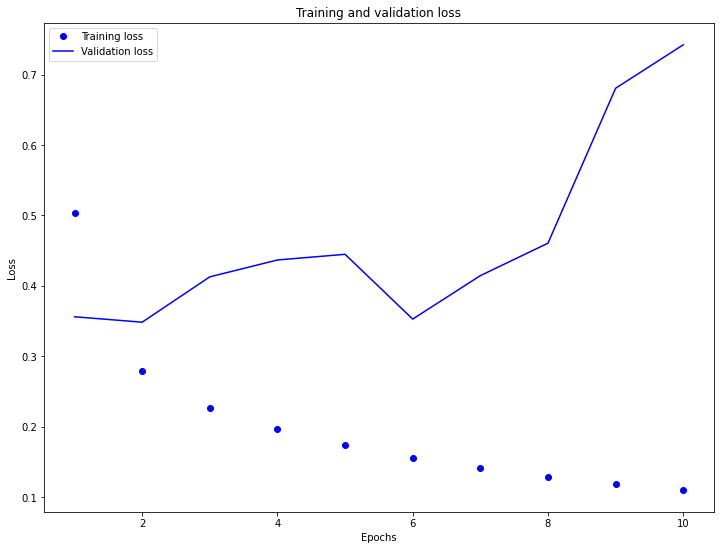

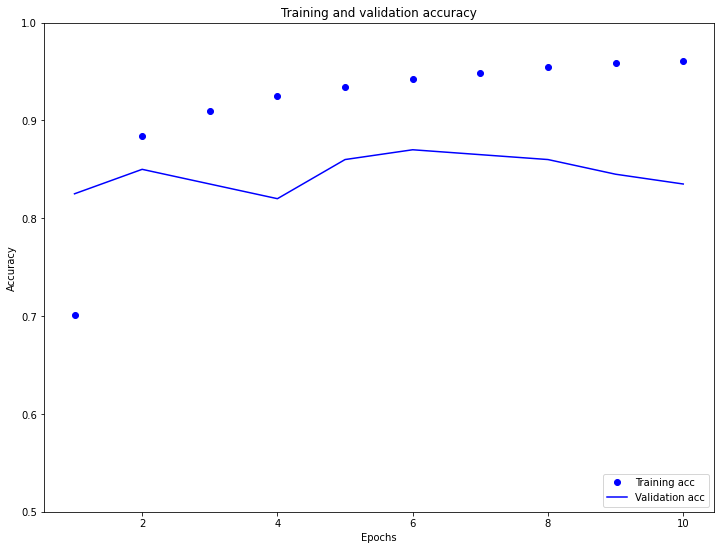

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn about recurrent networks see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).